# Init

In [ ]:
!unzip /content/drive/MyDrive/S1.zip -d /content/lots1/

Streaming output truncated to the last 5000 lines.
  inflating: /content/lots1/s1_13390.csv  
  inflating: /content/lots1/s1_13390.png  
  inflating: /content/lots1/s1_13391.csv  
  inflating: /content/lots1/s1_13391.png  
  inflating: /content/lots1/s1_13392.csv  
  inflating: /content/lots1/s1_13392.png  
  inflating: /content/lots1/s1_13393.csv  
  inflating: /content/lots1/s1_13393.png  
  inflating: /content/lots1/s1_13394.csv  
  inflating: /content/lots1/s1_13394.png  
  inflating: /content/lots1/s1_13395.csv  
  inflating: /content/lots1/s1_13395.png  
  inflating: /content/lots1/s1_13396.csv  
  inflating: /content/lots1/s1_13396.png  
  inflating: /content/lots1/s1_13397.csv  
  inflating: /content/lots1/s1_13397.png  
  inflating: /content/lots1/s1_13398.csv  
  inflating: /content/lots1/s1_13398.png  
  inflating: /content/lots1/s1_13399.csv  
  inflating: /content/lots1/s1_13399.png  
  inflating: /content/lots1/s1_13400.csv  
  inflating: /content/lots1/s1_13400.png  
  i

In [1]:
# Install necessary libraries
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install pyspark --quiet

# Standard library imports
import os
import subprocess
import threading
import time
import warnings
warnings.filterwarnings("ignore")

# Third-party imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms # Added for data augmentation

# MLflow imports
import mlflow
import mlflow.pytorch
from pyngrok import ngrok

# Spark imports
from pyspark.sql import SparkSession

# Suppress tqdm warnings if any
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.2 MB/s eta 0:00:00


# Parse csv

In [4]:
import os
import pandas as pd
from tqdm import tqdm

DATA_DIR = "/home/aoubaidi/Bureau/mlops_face_attribute_classification/GT1_G10/"
out_rows = []

def parse_mini_csv(path):
    # retourne dict {attribute: int(value)} ; tolerant aux espaces/quotes
    d = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = [p.strip().strip('"').strip("'") for p in line.split(",")]
            if len(parts) >= 2:
                key = parts[0]
                try:
                    val = int(parts[1])
                except:

                    try:
                        val = float(parts[1])
                    except:
                        val = parts[1]
                d[key] = val
    return d

for fname in tqdm(os.listdir(DATA_DIR)):
    if not fname.lower().endswith(".csv"):
        continue
    csv_path = os.path.join(DATA_DIR, fname)
    base = fname
    img_name = base + ".png"
    d = parse_mini_csv(csv_path)
    d["filename"] = img_name
    d["csv_file"] = fname
    out_rows.append(d)

df_wide = pd.DataFrame(out_rows).sort_values("filename").reset_index(drop=True)
print("Rows:", len(df_wide))
df_wide.head()


100%|██████████| 5113/5113 [00:00<00:00, 48183.09it/s]

Rows: 5113


,eye_angle,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance,filename,csv_file
0,2,0,0,0,1,7,2,3,14,82,0,6,7,3,0,1,2,1,s5_00000.csv.png,s5_00000.csv
1,1,1,1,0,0,4,0,3,14,77,0,5,7,5,4,2,1,1,s5_00001.csv.png,s5_00001.csv
2,2,0,0,1,1,5,0,3,14,62,4,6,5,3,3,2,0,1,s5_00002.csv.png,s5_00002.csv
3,1,0,1,1,0,10,1,2,14,54,0,10,6,3,0,1,0,1,s5_00003.csv.png,s5_00003.csv
4,0,1,1,0,0,7,3,4,3,29,4,9,6,3,1,2,1,2,s5_00004.csv.png,s5_00004.csv


In [5]:
df_wide.to_csv("new_labels.csv", index=False)

# Mapping des attributs

In [6]:
import pandas as pd

df = pd.read_csv('new_labels.csv')


In [7]:
NO_HAIR = {1, 14}

BEARD = {0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}
MUSTACHE = {0, 2, 3, 5, 6, 7, 8, 9, 10, 11}

def map_facial_hair(v):
    if v in NO_HAIR:
        return 0, 0
    beard = 1 if v in BEARD else 0
    mustache = 1 if v in MUSTACHE else 0
    return beard, mustache

df[["beard", "mustache"]] = df["facial_hair"].apply(lambda x: pd.Series(map_facial_hair(x)))


In [8]:
df["glasses_binary"] = df["glasses"].apply(lambda x: 0 if x == 11 else 1)


In [9]:
BALD = {0, 1, 2, 108, 109, 110}
SHORT = {8, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 31, 32, 39, 43, 44, 45, 46,
         49, 50, 51, 52, 53, 54, 61, 62, 66, 72, 73, 74, 76, 77, 83, 89, 92, 99,
         105, 107}
LONG = {3, 4, 5, 6, 7, 9, 10, 13, 15, 16, 24, 25, 26, 27, 28, 29, 30, 33, 34,
        35, 36, 37, 38, 40, 41, 42, 47, 48, 55, 56, 57, 58, 59, 60, 63, 64, 65,
        67, 68, 69, 70, 71, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91,
        93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106}

def map_hair_length(v):
    if v in BALD: return 0
    if v in SHORT: return 1
    if v in LONG: return 2
    return -1

df["hair_length"] = df["hair"].apply(map_hair_length)


In [10]:
BLOND = {0, 1, 4}
BROWN = {3, 5, 6}
RED = {2}
DARK = {7}
GREY_BLUE = {8, 9}

def map_hair_color(v):
    if v in BLOND: return 0   # blond
    if v in BROWN: return 1   # châtain
    if v in RED: return 2     # roux
    if v in DARK: return 3    # brun
    if v in GREY_BLUE: return 4
    return -1  # inconnu

df["hair_color_label"] = df["hair_color"].apply(map_hair_color)


In [13]:
final = df[[
    "filename",
    "beard",
    "mustache",
    "glasses_binary",
    "hair_color_label",
    "hair_length"
]]

final.to_csv("mapped_train.csv", index=False)
final.head()


,filename,beard,mustache,glasses_binary,hair_color_label,hair_length
0,s5_00000.csv.png,0,0,1,3,2
1,s5_00001.csv.png,0,0,1,3,1
2,s5_00002.csv.png,0,0,1,1,1
3,s5_00003.csv.png,0,0,1,1,1
4,s5_00004.csv.png,1,1,1,1,2


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mapped_train.csv")


Distribution barbe: beard
0    2916
1    2197
Name: count, dtype: int64
Distribution moustache: mustache
0    3254
1    1859
Name: count, dtype: int64
Distribution lunettes: glasses_binary
1    3894
0    1219
Name: count, dtype: int64
Distribution couleur cheveux: hair_color_label
1    1785
0    1275
4     849
3     673
2     531
Name: count, dtype: int64
Distribution longueur cheveux: hair_length
2    3286
1    1584
0     243
Name: count, dtype: int64


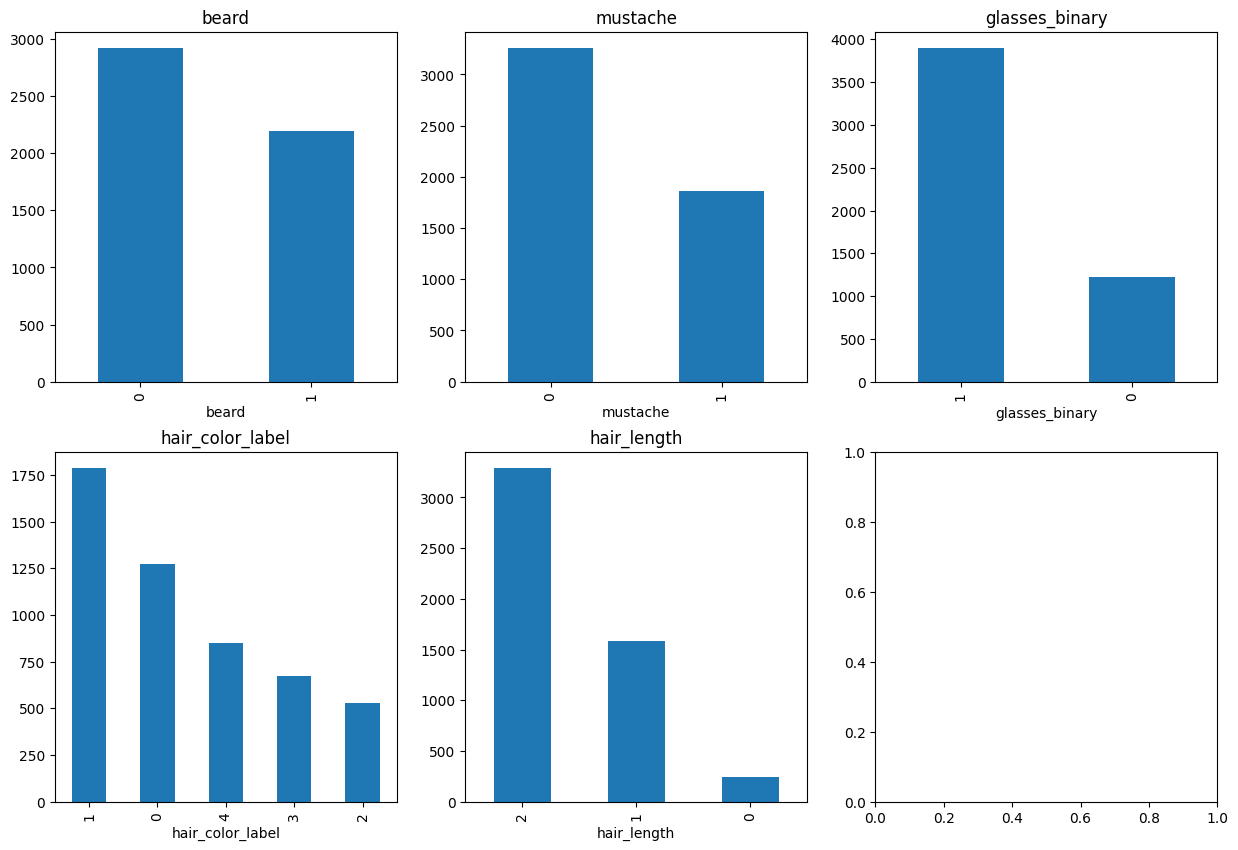

In [12]:
# Distribution des classes
print("Distribution barbe:", df['beard'].value_counts())
print("Distribution moustache:", df['mustache'].value_counts())
print("Distribution lunettes:", df['glasses_binary'].value_counts())
print("Distribution couleur cheveux:", df['hair_color_label'].value_counts())
print("Distribution longueur cheveux:", df['hair_length'].value_counts())

# Visualisation
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(['beard', 'mustache', 'glasses_binary', 'hair_color_label', 'hair_length']):
    df[col].value_counts().plot(kind='bar', ax=axes[i//3, i%3], title=col)

In [ ]:
def preprocess_image(path, size=224):
    img = cv2.imread(path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)[1]
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped, (size, size))
    return resized.astype("float32") / 255.0


In [ ]:
X = df["filename"].values
DATA_DIR= "lots1"
images_64 = []

for filename in X:
    path = os.path.join(DATA_DIR, filename)
    img = preprocess_image(path, size=64)
    images_64.append(img)

images_64 = np.array(images_64)
images_64.shape


(15890, 64, 64, 3)

In [ ]:
images_64[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [ ]:
import os
import cv2

output_dir = "lots1_proc"
os.makedirs(output_dir, exist_ok=True)


for i, img_array in enumerate(images_64):
    # Get the original filename to construct the new path
    original_filename = df["filename"].iloc[i]
    # Replace .csv.png with .png if present, or just use it as is if it's already .png
    if original_filename.endswith('.csv.png'):
        output_filename = original_filename.replace('.csv.png', '.png')
    else:
        output_filename = original_filename

    output_path = os.path.join(output_dir, output_filename)

    # Convert float32 [0,1] to uint8 [0,255] for saving with OpenCV
    img_to_save = (img_array * 255).astype('uint8')

    cv2.imwrite(output_path, img_to_save)

print(f"Saved {len(images_64)} processed images to {output_dir}")

Saved 15890 processed images to lots1_proc


In [ ]:

X = images_64
y = df[["beard","mustache","glasses_binary","hair_color_label","hair_length"]].values
print(f"X shape: {X.shape} first {X[5]}")
print(f"y shape: {y.shape}, first {y[0]}")
df.head()

X shape: (15890, 64, 64, 3) first [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
y shape: (15890, 5), first [1 1 1 0 1]


,filename,beard,mustache,glasses_binary,hair_color_label,hair_length
0,s1_00000.png,1,1,1,0,1
1,s1_00001.png,0,0,1,0,2
2,s1_00002.png,0,0,0,4,2
3,s1_00003.png,1,1,0,1,1
4,s1_00004.png,0,0,0,0,1


# Apache Spark

In [ ]:
# Installation des dépendances Spark pour Google Colab
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.0 pyspark_dist_explore==0.1.2 findspark==2.0.1

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import time
import pandas as pd

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


ImportError: cannot import name 'spline' from 'scipy.interpolate' (/usr/local/lib/python3.12/dist-packages/scipy/interpolate/__init__.py)

In [ ]:
# Configuration et démarrage de Spark
def start_spark_session():
    """Démarre une session Spark optimisée pour Colab"""
    spark = SparkSession.builder \
        .appName("FaceAttributesComparison") \
        .master("local[*]") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()

    print(" Spark session started")
    print(f" Spark version: {spark.version}")
    print(f" Java version: {spark.sparkContext._jvm.java.lang.System.getProperty('java.version')}")

    return spark

# Démarrer Spark
spark = start_spark_session()

 Spark session started
 Spark version: 3.5.0
 Java version: 17.0.16


In [ ]:
import os

# Create the Spark DataFrame by reading the CSV file
spark_df = spark.read.csv("final_data.csv", header=True, inferSchema=True)

print("Spark DataFrame Schema:")
spark_df.printSchema()

# Prepare the data
print("First 5 rows of Spark DataFrame:")
spark_df.show(5)

Spark DataFrame Schema:
root
 |-- eye_angle: integer (nullable = true)
 |-- eye_lashes: integer (nullable = true)
 |-- eye_lid: integer (nullable = true)
 |-- chin_length: integer (nullable = true)
 |-- eyebrow_weight: integer (nullable = true)
 |-- eyebrow_shape: integer (nullable = true)
 |-- eyebrow_thickness: integer (nullable = true)
 |-- face_shape: integer (nullable = true)
 |-- facial_hair: integer (nullable = true)
 |-- hair: integer (nullable = true)
 |-- eye_color: integer (nullable = true)
 |-- face_color: integer (nullable = true)
 |-- hair_color: integer (nullable = true)
 |-- glasses: integer (nullable = true)
 |-- glasses_color: integer (nullable = true)
 |-- eye_slant: integer (nullable = true)
 |-- eyebrow_width: integer (nullable = true)
 |-- eye_eyebrow_distance: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- csv_file: string (nullable = true)

First 5 rows of Spark DataFrame:
+---------+----------+-------+-----------+--------------+---------

In [ ]:
# Définition des User Defined Functions (UDFs) pour Spark
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import IntegerType

# Mapping de la couleur des cheveux
def map_hair_color_spark(hair_color):
    BLOND = {0, 1, 4}
    BROWN = {3, 5, 6}
    RED = {2}
    DARK = {7}
    GREY_BLUE = {8, 9}

    if hair_color in BLOND: return 0
    if hair_color in BROWN: return 1
    if hair_color in RED: return 2
    if hair_color in DARK: return 3
    if hair_color in GREY_BLUE: return 4
    return -1

# Mapping de la longueur des cheveux
def map_hair_length_spark(hair):
    BALD = {0, 1, 2, 108, 109, 110}
    SHORT = {8, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 31, 32, 39, 43, 44, 45, 46,
             49, 50, 51, 52, 53, 54, 61, 62, 66, 72, 73, 74, 76, 77, 83, 89, 92, 99,
             105, 107}
    LONG = {3, 4, 5, 6, 7, 9, 10, 13, 15, 16, 24, 25, 26, 27, 28, 29, 30, 33, 34,
            35, 36, 37, 38, 40, 41, 42, 47, 48, 55, 56, 57, 58, 59, 60, 63, 64, 65,
            67, 68, 69, 70, 71, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91,
            93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106}

    if hair in BALD: return 0
    if hair in SHORT: return 1
    if hair in LONG: return 2
    return -1

# Mapping de la pilosité faciale
def map_facial_hair_beard_spark(facial_hair):
    NO_HAIR = {1, 14}
    BEARD = {0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}

    if facial_hair in NO_HAIR:
        return 0
    return 1 if facial_hair in BEARD else 0

def map_facial_hair_mustache_spark(facial_hair):
    NO_HAIR = {1, 14}
    MUSTACHE = {0, 2, 3, 5, 6, 7, 8, 9, 10, 11}

    if facial_hair in NO_HAIR:
        return 0
    return 1 if facial_hair in MUSTACHE else 0

# Enregistrement des UDFs
hair_color_udf = udf(map_hair_color_spark, IntegerType())
hair_length_udf = udf(map_hair_length_spark, IntegerType())
beard_udf = udf(map_facial_hair_beard_spark, IntegerType())
mustache_udf = udf(map_facial_hair_mustache_spark, IntegerType())

print(" UDFs Spark enregistrées")

✅ UDFs Spark enregistrées


In [ ]:
def spark_data_processing(spark_df):
    """Traitement des données avec Spark"""

    start_time = time.time()

    # Application des transformations Spark
    processed_df = spark_df \
        .withColumn("hair_color_label", hair_color_udf(col("hair_color"))) \
        .withColumn("hair_length_label", hair_length_udf(col("hair"))) \
        .withColumn("beard_label", beard_udf(col("facial_hair"))) \
        .withColumn("mustache_label", mustache_udf(col("facial_hair"))) \
        .withColumn("glasses_binary", when(col("glasses") > 0, 1).otherwise(0)) \
        .drop("hair_color", "hair", "facial_hair", "glasses")

    # Forcer l'exécution
    row_count = processed_df.count()
    processing_time = time.time() - start_time

    print(f" Traitement Spark terminé en {processing_time:.2f} secondes")
    print(f" {row_count} lignes traitées")

    return processed_df, processing_time

# Exécuter le traitement Spark
spark_processed_df, spark_time = spark_data_processing(spark_df)
spark_processed_df.show(10)

⚡ Traitement Spark terminé en 1.04 secondes
 15890 lignes traitées
+---------+----------+-------+-----------+--------------+-------------+-----------------+----------+---------+----------+-------------+---------+-------------+--------------------+------------+------------+----------------+-----------------+-----------+--------------+--------------+
|eye_angle|eye_lashes|eye_lid|chin_length|eyebrow_weight|eyebrow_shape|eyebrow_thickness|face_shape|eye_color|face_color|glasses_color|eye_slant|eyebrow_width|eye_eyebrow_distance|    filename|    csv_file|hair_color_label|hair_length_label|beard_label|mustache_label|glasses_binary|
+---------+----------+-------+-----------+--------------+-------------+-----------------+----------+---------+----------+-------------+---------+-------------+--------------------+------------+------------+----------------+-----------------+-----------+--------------+--------------+
|        2|         1|      1|          0|             0|            0|          

In [ ]:
final_spark_df = spark_processed_df.select(
    "filename",
    "beard_label",
    "mustache_label",
    "glasses_binary",
    "hair_color_label",
    "hair_length_label"
)

print("Final Spark DataFrame Schema:")
final_spark_df.printSchema()

print("First 5 rows of the final Spark DataFrame:")
final_spark_df.show(5)

Final Spark DataFrame Schema:
root
 |-- filename: string (nullable = true)
 |-- beard_label: integer (nullable = true)
 |-- mustache_label: integer (nullable = true)
 |-- glasses_binary: integer (nullable = false)
 |-- hair_color_label: integer (nullable = true)
 |-- hair_length_label: integer (nullable = true)

First 5 rows of the final Spark DataFrame:
+------------+-----------+--------------+--------------+----------------+-----------------+
|    filename|beard_label|mustache_label|glasses_binary|hair_color_label|hair_length_label|
+------------+-----------+--------------+--------------+----------------+-----------------+
|s1_00000.png|          1|             1|             1|               0|                1|
|s1_00001.png|          0|             0|             1|               0|                2|
|s1_00002.png|          0|             0|             1|               4|                2|
|s1_00003.png|          1|             1|             1|               1|                1|

In [ ]:
import os
from pyspark.sql.types import StructField # Import StructField

def spark_preprocess_image(filename: str, size: int = 64):
    # Ensure DATA_DIR is accessible. It's a global variable from previous cells.
    global DATA_DIR
    image_path = os.path.join(DATA_DIR, filename)
    processed_image = preprocess_image(image_path, size=size)

    if processed_image is None:
        # Return None or handle error, e.g., return default values
        return None

    # Flatten the image and get its dimensions
    height, width, channels = processed_image.shape
    flattened_image = processed_image.flatten().tolist()

    return {"image_data": flattened_image, "height": height, "width": width, "channels": channels}

# Define the return type for the UDF
image_preprocessing_schema = StructType([
    StructField("image_data", ArrayType(FloatType()), True), # 'image_data'
    StructField("height", IntegerType(), True),          # 'height'
    StructField("width", IntegerType(), True),           # 'width'
    StructField("channels", IntegerType(), True)          # 'channels'
])

# Register the UDF
spark_preprocess_image_udf = udf(spark_preprocess_image, image_preprocessing_schema)

print("PySpark UDF 'spark_preprocess_image_udf' defined and registered.")

PySpark UDF 'spark_preprocess_image_udf' defined and registered.


In [ ]:
import numpy as np

# Apply the UDF to the Spark DataFrame
print("Applying Spark UDF for image preprocessing...")
spark_processed_images_df = spark_df.withColumn("processed_image_data", spark_preprocess_image_udf(spark_df["filename"]))

# Filter out any rows where preprocessing failed (returned None)
spark_processed_images_df = spark_processed_images_df.filter(spark_processed_images_df["processed_image_data"].isNotNull())

# Collect the results to the driver as a Pandas DataFrame
print("Collecting processed image data from Spark...")
pandas_processed_images = spark_processed_images_df.select("filename", "processed_image_data.*").toPandas()

# Reconstruct images into a NumPy array
reconstructed_images = []
for index, row in tqdm(pandas_processed_images.iterrows(), total=len(pandas_processed_images), desc="Reconstructing images"):
    img_data = row['image_data']
    height = row['height']
    width = row['width']
    channels = row['channels']
    reconstructed_img = np.array(img_data).reshape(height, width, channels)
    reconstructed_images.append(reconstructed_img)

images_64_spark = np.array(reconstructed_images)

print(f"Original X shape: {X.shape}")
print(f"Spark processed images shape: {images_64_spark.shape}")
print("Spark-based image preprocessing complete and images reconstructed.")

# Update X to use the Spark processed images
X_spark = images_64_spark

Applying Spark UDF for image preprocessing...


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59178)
Traceback (most recent call last):
  File "/usr/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.12/socketserver.py", line 766, in __init__
    self.handle()
  File "/usr/local/lib/python3.12/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.12/dist-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyspark/accumulators.py", line 271, in accum_u

Py4JError: An error occurred while calling None.None

In [ ]:
import numpy as np

# Apply the UDF to the Spark DataFrame
print("Applying Spark UDF for image preprocessing...")
spark_processed_images_df = spark_df.withColumn("processed_image_data", spark_preprocess_image_udf(col("filename")))

# Filter out any rows where preprocessing failed (returned None)
spark_processed_images_df = spark_processed_images_df.filter(spark_processed_images_df["processed_image_data"].isNotNull())

# Collect the results to the driver as a Pandas DataFrame
print("Collecting processed image data from Spark...")
pandas_processed_images = spark_processed_images_df.select("filename", "processed_image_data.*", "beard_label", "mustache_label", "glasses_binary", "hair_color_label", "hair_length_label").toPandas()

# Reconstruct images into a NumPy array
reconstructed_images = []
for index, row in tqdm(pandas_processed_images.iterrows(), total=len(pandas_processed_images), desc="Reconstructing images"):
    img_data = row['image_data']
    height = row['height']
    width = row['width']
    channels = row['channels']
    reconstructed_img = np.array(img_data).reshape(height, width, channels)
    reconstructed_images.append(reconstructed_img)

images_64_spark = np.array(reconstructed_images)

print(f"Original X shape: {X.shape}")
print(f"Spark processed images shape: {images_64_spark.shape}")
print("Spark-based image preprocessing complete and images reconstructed.")

# Update X and y to use the Spark processed images and corresponding labels
X_spark = images_64_spark
y_spark = pandas_processed_images[["beard_label", "mustache_label", "glasses_binary", "hair_color_label", "hair_length_label"]].values

Applying Spark UDF for image preprocessing...


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `beard_label` cannot be resolved. Did you mean one of the following? [`eye_lashes`, `eye_lid`, `eye_slant`, `face_shape`, `csv_file`].;
'Project [filename#137, processed_image_data#657.image_data AS image_data#679, processed_image_data#657.height AS height#680, processed_image_data#657.width AS width#681, processed_image_data#657.channels AS channels#682, 'beard_label, 'mustache_label, 'glasses_binary, 'hair_color_label, 'hair_length_label]
+- Filter isnotnull(processed_image_data#657)
   +- Project [eye_angle#119, eye_lashes#120, eye_lid#121, chin_length#122, eyebrow_weight#123, eyebrow_shape#124, eyebrow_thickness#125, face_shape#126, facial_hair#127, hair#128, eye_color#129, face_color#130, hair_color#131, glasses#132, glasses_color#133, eye_slant#134, eyebrow_width#135, eye_eyebrow_distance#136, filename#137, csv_file#138, spark_preprocess_image(filename#137)#656 AS processed_image_data#657]
      +- Relation [eye_angle#119,eye_lashes#120,eye_lid#121,chin_length#122,eyebrow_weight#123,eyebrow_shape#124,eyebrow_thickness#125,face_shape#126,facial_hair#127,hair#128,eye_color#129,face_color#130,hair_color#131,glasses#132,glasses_color#133,eye_slant#134,eyebrow_width#135,eye_eyebrow_distance#136,filename#137,csv_file#138] csv


# DataLoader and CNN archi

In [ ]:
class MultiHeadNet(nn.Module):
    def __init__(self, n_color=5, n_length=3):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 32x32

            nn.Dropout(0.1),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 16x16

            nn.Dropout(0.2),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 8x8

            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )
        # head

        self.head_beard = nn.Linear(256,1)
        self.head_mustache = nn.Linear(256,1)
        self.head_glasses = nn.Linear(256,1)
        self.head_color = nn.Linear(256, n_color)
        self.head_length = nn.Linear(256, n_length)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialisation correcte des poids"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return {
            "beard": self.head_beard(x).squeeze(1),
            "mustache": self.head_mustache(x).squeeze(1),
            "glasses": self.head_glasses(x).squeeze(1),
            "hair_color": self.head_color(x),
            "hair_length": self.head_length(x)
        }

#  **Architecture détaillée de MultiHeadNet**

##  **CONCEPT GLOBAL : "ONE BACKBONE, MULTIPLE HEADS"**

```python
Input Image (64x64x3)
     ↓
BACKBONE CNN (Extracteur de features universel)
     ↓  
Features vector (256 dimensions)
     ↓
MULTI-HEAD CLASSIFICATION
├── HEAD 1: Barbe? (Oui/Non)
├── HEAD 2: Moustache? (Oui/Non)  
├── HEAD 3: Lunettes? (Oui/Non)
├── HEAD 4: Couleur cheveux (5 classes)
└── HEAD 5: Longueur cheveux (3 classes)
```

---

##  **DÉCOMPOSITION COUCHE PAR COUCHE**

### ** INPUT LAYER**
```python
Input: Tensor [batch_size, 3, 64, 64]
# 3 canaux: RGB | 64x64 pixels | batch_size: nombre d'images
```

---

### ** BACKBONE CNN (Extracteur de caractéristiques)**

#### ** BLOC 1 : Extraction bas niveau**
```python
nn.Conv2d(3, 32, 3, padding=1)      # → [batch, 32, 64, 64]
```
- **3 → 32 channels** : Passe de RGB à 32 features maps
- **Kernel 3x3** : Détecte bords, textures simples
- **Padding 1** : Préserve la taille spatiale (64x64)

```python
nn.BatchNorm2d(32)                  # → [batch, 32, 64, 64]
```
- **Stabilise l'apprentissage** : Normalise les activations
- **Réduit l'overfitting** : Effet régularisateur
- **Permet learning rate plus élevé**

```python
nn.ReLU()                           # → [batch, 32, 64, 64]
```
- **Non-linéarité** : `max(0, x)`
- **Sparse les activations** : Seules les features importantes s'activent

```python
nn.MaxPool2d(2)                     # → [batch, 32, 32, 32]
```
- **Réduction dimension** : 64x64 → 32x32
- **Invariance translation** : Garde les features les plus actives
- **Réduction calculs** : ÷4 le nombre de pixels

```python
nn.Dropout(0.1)                     # → [batch, 32, 32, 32]
```
- **Régularisation** : Désactive aléatoirement 10% des neurones
- **Empêche la co-adaptation** : Force la redondance des features

#### **BLOC 2 : Extraction niveau intermédiaire**
```python
nn.Conv2d(32, 64, 3, padding=1)     # → [batch, 64, 32, 32]
```
- **32 → 64 channels** : Double la complexité des features
- **Détecte motifs complexes** : Yeux, nez, formes faciales

```python
nn.BatchNorm2d(64)                  # → [batch, 64, 32, 32]
nn.ReLU()                           # → [batch, 64, 32, 32]
nn.MaxPool2d(2)                     # → [batch, 64, 16, 16]
nn.Dropout(0.2)                     # → [batch, 64, 16, 16]
```
- **Dropout augmenté à 20%** : Plus de régularisation car plus de paramètres

#### ** BLOC 3 : Extraction haut niveau**
```python
nn.Conv2d(64, 128, 3, padding=1)    # → [batch, 128, 16, 16]
```
- **64 → 128 channels** : Features très abstraites
- **Détecte concepts** : "visage avec barbe", "cheveux longs"

```python
nn.BatchNorm2d(128)                 # → [batch, 128, 16, 16]
nn.ReLU()                           # → [batch, 128, 16, 16]
nn.MaxPool2d(2)                     # → [batch, 128, 8, 8]
```

#### ** POOLING FINAL : Global Feature Vector**
```python
nn.AdaptiveAvgPool2d((1,1))         # → [batch, 128, 1, 1]
```
- **Pooling adaptatif** : Réduit n'importe quelle taille à 1x1
- **Vectorisation** : Chaque channel devient une feature globale
- **Résultat** : 128 valeurs représentant l'image entière

---

### ** CONNECTED LAYER**
```python
nn.Flatten()                        # → [batch, 128]
nn.Linear(128, 256)                 # → [batch, 256]
nn.ReLU()                           # → [batch, 256]
```

- **Flatten** : [128, 1, 1] → [128] (vectorise les features)
- **128 → 256 neurones** : Augmente la capacité de représentation
- **Combinaison non-linéaire** des features CNN

---

##  **MULTI-HEAD CLASSIFICATION**

### **HEAD 1 : DÉTECTION BARBE**
```python
self.head_beard = nn.Linear(256, 1)  # → [batch, 1]
"beard": self.head_beard(x).squeeze(1)  # → [batch]
```
- **Regression logistique** : 1 sortie → probabilité
- **squeeze(1)** : Enlève la dimension inutile [batch, 1] → [batch]
- **Loss** : `BCEWithLogitsLoss` (Binary Cross Entropy avec sigmoid intégré)

### **HEAD 2 : DÉTECTION MOUSTACHE**
```python
self.head_mustache = nn.Linear(256, 1)  # → [batch, 1]
"mustache": self.head_mustache(x).squeeze(1)  # → [batch]
```
- **Même architecture** que barbe mais poids différents
- **Apprentissage indépendant**

### **HEAD 3 : DÉTECTION LUNETTES**
```python
self.head_glasses = nn.Linear(256, 1)  # → [batch, 1]
"glasses": self.head_glasses(x).squeeze(1)  # → [batch]
```
- **Classification binaire** : Avec/sans lunettes

### **HEAD 4 : COULEUR CHEVEUX**
```python
self.head_color = nn.Linear(256, n_color)  # → [batch, 5]
"hair_color": self.head_color(x)           # → [batch, 5]
```
- **Classification multi-classes** : 5 couleurs possibles
- **Sortie** : Logits pour chaque classe (pas de softmax)
- **Loss** : `CrossEntropyLoss` (inclut softmax + cross entropy)

### **HEAD 5 : LONGUEUR CHEVEUX**
```python
self.head_length = nn.Linear(256, n_length)  # → [batch, 3]
"hair_length": self.head_length(x)           # → [batch, 3]
```
- **Classification multi-classes** : 3 longueurs possibles

---

##  **INITIALISATION DES POIDS**

### **Mécanisme Kaiming/He**
```python
nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
```
- **Spécialement pour ReLU** : Préserve la variance des activations
- **'fan_out'** : Basé sur le nombre de neurones de sortie
- **Évite vanishing/exploding gradients**

### **BatchNorm Initialisation**
```python
nn.init.constant_(m.weight, 1)  # Scale initial
nn.init.constant_(m.bias, 0)    # Bias initial
```
- **Scale=1, Bias=0** : Transformation identité au début
- **S'ajuste pendant l'entraînement**

### **Couches Linear**
```python
nn.init.normal_(m.weight, 0, 0.01)  # Petits poids aléatoires
nn.init.constant_(m.bias, 0)        # Bias à zéro
```

---

##  **FLOW  DES DONNÉES**

```
Image (64x64x3)
     ↓
[CONV1] 3→32 + BatchNorm + ReLU + MaxPool → 32x32x32 + Dropout 10%
     ↓
[CONV2] 32→64 + BatchNorm + ReLU + MaxPool → 16x16x64 + Dropout 20%  
     ↓
[CONV3] 64→128 + BatchNorm + ReLU + MaxPool → 8x8x128
     ↓
AdaptiveAvgPool → 1x1x128
     ↓
Flatten → 128 features
     ↓  
[FC] 128→256 + ReLU → 256 features abstraites
     ↓
[MULTI-HEAD]
├── Linear(256→1) → Barbe logit
├── Linear(256→1) → Moustache logit  
├── Linear(256→1) → Lunettes logit
├── Linear(256→5) → Couleur logits
└── Linear(256→3) → Longueur logits
```

---

##  **STRATÉGIE MULTI-TÂCHES**

### **PARTAGE DE CONNAISSANCES**
- **Backbone commun** : Apprend des features génériques du visage
- **Économie de paramètres** : 1 extracteur pour 5 tâches
- **Transfert learning interne** : Connaissances partagées entre tâches

### **SPÉCIALISATION PAR TÂCHE**
- **Heads séparés** : Chaque tête se spécialise dans sa tâche
- **Pas d'interférence** : Les poids sont indépendants
- **Fine-tuning** : Chaque tête peut apprendre à son rythme

---

##  **MÉCANISMES OVERFITTING**

1. **BatchNorm** : Régularisation et stabilisation
2. **Dropout progressif** : 10% → 20% selon la profondeur  
3. **MaxPooling** : Invariance et réduction dimension
4. **Weight Decay** : Dans l'optimizer (L2 regularization)
5. **Early Stopping** : Basé sur la validation loss



In [ ]:
bce = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiHeadNet(n_color=5, n_length=3).to(device)
EPOCHS = 10

In [ ]:
import torch.optim as optim

# Define loss functions for each head
loss_beard = nn.BCEWithLogitsLoss() # Binary classification
loss_mustache = nn.BCEWithLogitsLoss() # Binary classification
loss_glasses = nn.BCEWithLogitsLoss() # Binary classification
loss_hair_color = nn.CrossEntropyLoss() # Multi-class classification
loss_hair_length = nn.CrossEntropyLoss() # Multi-class classification

# Combine loss functions into a dictionary for easier access
losses = {
    "beard": loss_beard,
    "mustache": loss_mustache,
    "glasses": loss_glasses,
    "hair_color": loss_hair_color,
    "hair_length": loss_hair_length
}

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        # The labels need to be split for each head
        # Assuming labels are in the order: beard, mustache, glasses_binary, hair_color_label, hair_length
        label_beard = self.labels[idx, 0].float() # Binary target should be float for BCEWithLogitsLoss
        label_mustache = self.labels[idx, 1].float()
        label_glasses = self.labels[idx, 2].float()
        label_hair_color = self.labels[idx, 3]
        label_hair_length = self.labels[idx, 4]

        return image, {
            "beard": label_beard,
            "mustache": label_mustache,
            "glasses": label_glasses,
            "hair_color": label_hair_color,
            "hair_length": label_hair_length
        }

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (12712, 64, 64, 3)
X_val shape: (3178, 64, 64, 3)
y_train shape: (12712, 5)
y_val shape: (3178, 5)


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


val_transforms = None
train_dataset = ImageDataset(X_train, y_train, transform=train_transforms)
val_dataset = ImageDataset(X_val, y_val, transform=val_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 398
Number of validation batches: 100


In [ ]:
train_dataset[0]

(tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ...,

In [ ]:
def debug_data_pipeline():
    """Debug du pipeline de données"""
    print("\n DEBUG DU PIPELINE DE DONNÉES:")

    # Vérifier un batch
    for images, targets in train_loader:
        print(f"Batch images shape: {images.shape}")
        print(f"Batch images range: [{images.min():.3f}, {images.max():.3f}]")

        # Vérifier les targets
        for attr, values in targets.items():
            print(f"{attr:12}: shape {values.shape}, unique values: {torch.unique(values)}")

        # Vérifier un échantillon
        sample_idx = 0
        print(f"\n ÉCHANTILLON #{sample_idx}:")
        for attr, values in targets.items():
            print(f"{attr:12}: {values[sample_idx]}")

        break  # Un seul batch

debug_data_pipeline()


 DEBUG DU PIPELINE DE DONNÉES:
Batch images shape: torch.Size([32, 3, 64, 64])
Batch images range: [0.000, 1.000]
beard       : shape torch.Size([32]), unique values: tensor([0., 1.])
mustache    : shape torch.Size([32]), unique values: tensor([0., 1.])
glasses     : shape torch.Size([32]), unique values: tensor([0., 1.])
hair_color  : shape torch.Size([32]), unique values: tensor([0, 1, 2, 3, 4])
hair_length : shape torch.Size([32]), unique values: tensor([0, 1, 2])

 ÉCHANTILLON #0:
beard       : 1.0
mustache    : 1.0
glasses     : 0.0
hair_color  : 4
hair_length : 2


## Define Training Loop Function


In [ ]:
from  sklearn.metrics import accuracy_score

def train_one_epoch(model, loader, optimizer, device, epoch):
    """Version stabilisée de l'entraînement"""
    model.train()
    running_loss = 0
    running_losses = {"beard": 0, "mustache": 0, "glasses": 0, "hair_color": 0, "hair_length": 0}

    for batch_idx, (imgs, targets) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
        imgs = imgs.to(device)
        t_beard = targets["beard"].to(device)
        t_mustache = targets["mustache"].to(device)
        t_glasses = targets["glasses"].to(device)
        t_color = targets["hair_color"].to(device)
        t_length = targets["hair_length"].to(device)

        # Forward pass
        outs = model(imgs)

        loss_beard = bce(outs["beard"], t_beard)
        loss_mustache = bce(outs["mustache"], t_mustache)
        loss_glasses = bce(outs["glasses"], t_glasses)
        loss_color = ce(outs["hair_color"], t_color)
        loss_length = ce(outs["hair_length"], t_length)

        #PONDÉRATION
        total_loss = (
            loss_beard * 1.0 +
            loss_mustache * 1.0 +
            loss_glasses * 2.0 +
            loss_color * 0.8 +
            loss_length * 1.0
        )

        # Backward pass avec gradient clipping
        optimizer.zero_grad()
        total_loss.backward()

        # GRADIENT CLIPPING
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += total_loss.item()
        running_losses["beard"] += loss_beard.item()
        running_losses["mustache"] += loss_mustache.item()
        running_losses["glasses"] += loss_glasses.item()
        running_losses["hair_color"] += loss_color.item()
        running_losses["hair_length"] += loss_length.item()

        # LOGGING BATCH (seulement 1 batch / epoch)
        if batch_idx == 0:
            print(f" BATCH 0 - Losses:")
            print(f"   beard: {loss_beard.item():.4f}")
            print(f"   mustache: {loss_mustache.item():.4f}")
            print(f"   glasses: {loss_glasses.item():.4f}")
            print(f"   color: {loss_color.item():.4f}")
            print(f"   length: {loss_length.item():.4f}")
            print(f"   TOTAL: {total_loss.item():.4f}")

            # Prédictions du batch
            with torch.no_grad():
                beard_acc = ((torch.sigmoid(outs["beard"]) > 0.5).float() == t_beard).float().mean().item()
                mustache_acc = ((torch.sigmoid(outs["mustache"]) > 0.5).float() == t_mustache).float().mean().item()
                glasses_acc = ((torch.sigmoid(outs["glasses"]) > 0.5).float() == t_glasses).float().mean().item()

                print(f" BATCH 0 - Prédictions:")
                print(f"   beard: acc={beard_acc:.3f}")
                print(f"   mustache: acc={mustache_acc:.3f}")
                print(f"   glasses: acc={glasses_acc:.3f}")

    # Calcul des moyennes
    avg_total_loss = running_loss / len(loader)
    for k in running_losses:
        running_losses[k] /= len(loader)

    print(f" MOYENNES EPOCH - Total: {avg_total_loss:.4f}")
    for attr, loss_val in running_losses.items():
        print(f"   {attr:12}: {loss_val:.4f}")

    return avg_total_loss

def validate(model, loader, device):
    """Version stabilisée de la validation"""
    model.eval()
    running_loss = 0
    all_preds = {"beard":[], "mustache":[], "glasses":[], "hair_color":[], "hair_length":[]}
    all_trues = {"beard":[], "mustache":[], "glasses":[], "hair_color":[], "hair_length":[]}

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Validation"):
            imgs = imgs.to(device)
            t_beard = targets["beard"].to(device)
            t_mustache = targets["mustache"].to(device)
            t_glasses = targets["glasses"].to(device)
            t_color = targets["hair_color"].to(device)
            t_length = targets["hair_length"].to(device)

            outs = model(imgs)

            # Même calcul de loss qu'à l'entraînement
            loss_beard = bce(outs["beard"], t_beard)
            loss_mustache = bce(outs["mustache"], t_mustache)
            loss_glasses = bce(outs["glasses"], t_glasses)
            loss_color = ce(outs["hair_color"], t_color)
            loss_length = ce(outs["hair_length"], t_length)

            total_loss = (
                loss_beard * 1.0 +
                loss_mustache * 1.0 +
                loss_glasses * 2.0 +
                loss_color * 0.8 +
                loss_length * 1.0
            )

            running_loss += total_loss.item()

            # Collecte des prédictions
            pb = (torch.sigmoid(outs["beard"]) > 0.5).cpu().numpy().astype(int)
            pm = (torch.sigmoid(outs["mustache"]) > 0.5).cpu().numpy().astype(int)
            pg = (torch.sigmoid(outs["glasses"]) > 0.5).cpu().numpy().astype(int)
            pc = outs["hair_color"].argmax(dim=1).cpu().numpy()
            pl = outs["hair_length"].argmax(dim=1).cpu().numpy()

            all_preds["beard"].extend(pb.tolist())
            all_preds["mustache"].extend(pm.tolist())
            all_preds["glasses"].extend(pg.tolist())
            all_preds["hair_color"].extend(pc.tolist())
            all_preds["hair_length"].extend(pl.tolist())

            all_trues["beard"].extend(t_beard.cpu().numpy().astype(int).tolist())
            all_trues["mustache"].extend(t_mustache.cpu().numpy().astype(int).tolist())
            all_trues["glasses"].extend(t_glasses.cpu().numpy().astype(int).tolist())
            all_trues["hair_color"].extend(t_color.cpu().numpy().tolist())
            all_trues["hair_length"].extend(t_length.cpu().numpy().tolist())

    # Calcul des accuracies
    accs = {}
    for k in all_preds:
        accs[k] = accuracy_score(all_trues[k], all_preds[k])

    return running_loss / len(loader), accs


 EPOCH 1/10


Epoch 1:   1%|          | 3/398 [00:00<00:18, 20.97it/s]

 BATCH 0 - Losses:
   beard: 0.6923
   mustache: 0.6920
   glasses: 0.6955
   color: 1.6120
   length: 1.0982
   TOTAL: 5.1633
 BATCH 0 - Prédictions:
   beard: acc=0.562
   mustache: acc=0.594
   glasses: acc=0.250


Epoch 1: 100%|██████████| 398/398 [00:18<00:00, 21.18it/s]


 MOYENNES EPOCH - Total: 3.6665
   beard       : 0.6084
   mustache    : 0.5468
   glasses     : 0.5895
   hair_color  : 0.7582
   hair_length : 0.7256


Validation: 100%|██████████| 100/100 [00:00<00:00, 205.07it/s]
2025/11/20 08:06:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:06:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 1:
   Train Loss: 3.6665
   Val Loss:   3.2251
   LR:         9.76e-04

 ACCURACIES:
   beard       : 0.7045 (70.5%)
   mustache    : 0.7605 (76.1%)
   glasses     : 0.7772 (77.7%)
   hair_color  : 0.6743 (67.4%)
   hair_length : 0.7498 (75.0%)


2025/11/20 08:06:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:06:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 1!
   Val Loss: 3.2251

 EPOCH 2/10


Epoch 2:   1%|          | 2/398 [00:00<00:30, 13.14it/s]

 BATCH 0 - Losses:
   beard: 0.5622
   mustache: 0.4996
   glasses: 0.4181
   color: 0.6132
   length: 0.4714
   TOTAL: 2.8599
 BATCH 0 - Prédictions:
   beard: acc=0.656
   mustache: acc=0.750
   glasses: acc=0.875


Epoch 2: 100%|██████████| 398/398 [00:19<00:00, 20.85it/s]


 MOYENNES EPOCH - Total: 2.4474
   beard       : 0.5934
   mustache    : 0.5299
   glasses     : 0.2501
   hair_color  : 0.4919
   hair_length : 0.4304


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.80it/s]



 RÉSULTATS EPOCH 2:
   Train Loss: 2.4474
   Val Loss:   3.3415
   LR:         9.05e-04

 ACCURACIES:
   beard       : 0.6992 (69.9%)
   mustache    : 0.7605 (76.1%)
   glasses     : 0.6910 (69.1%)
   hair_color  : 0.7542 (75.4%)
   hair_length : 0.7212 (72.1%)
 Early stopping: 1/8

 EPOCH 3/10


Epoch 3:   1%|          | 2/398 [00:00<00:20, 19.40it/s]

 BATCH 0 - Losses:
   beard: 0.6293
   mustache: 0.5221
   glasses: 0.0597
   color: 0.4962
   length: 0.2608
   TOTAL: 1.9287
 BATCH 0 - Prédictions:
   beard: acc=0.656
   mustache: acc=0.781
   glasses: acc=1.000


Epoch 3: 100%|██████████| 398/398 [00:19<00:00, 20.89it/s]


 MOYENNES EPOCH - Total: 1.9051
   beard       : 0.5479
   mustache    : 0.4928
   glasses     : 0.0983
   hair_color  : 0.4301
   hair_length : 0.3237


Validation: 100%|██████████| 100/100 [00:00<00:00, 167.82it/s]



 RÉSULTATS EPOCH 3:
   Train Loss: 1.9051
   Val Loss:   3.8941
   LR:         7.94e-04

 ACCURACIES:
   beard       : 0.7524 (75.2%)
   mustache    : 0.8181 (81.8%)
   glasses     : 0.5642 (56.4%)
   hair_color  : 0.8581 (85.8%)
   hair_length : 0.8905 (89.0%)
 Early stopping: 2/8

 EPOCH 4/10


Epoch 4:   1%|          | 2/398 [00:00<00:27, 14.45it/s]

 BATCH 0 - Losses:
   beard: 0.3429
   mustache: 0.3719
   glasses: 0.1009
   color: 0.3787
   length: 0.3345
   TOTAL: 1.5541
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=0.844
   glasses: acc=0.969


Epoch 4: 100%|██████████| 398/398 [00:19<00:00, 20.40it/s]


 MOYENNES EPOCH - Total: 1.2878
   beard       : 0.3130
   mustache    : 0.3115
   glasses     : 0.0541
   hair_color  : 0.3904
   hair_length : 0.2427


Validation: 100%|██████████| 100/100 [00:00<00:00, 207.92it/s]
2025/11/20 08:07:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:07:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 4:
   Train Loss: 1.2878
   Val Loss:   1.9468
   LR:         6.55e-04

 ACCURACIES:
   beard       : 0.8096 (81.0%)
   mustache    : 0.8480 (84.8%)
   glasses     : 0.9305 (93.0%)
   hair_color  : 0.8638 (86.4%)
   hair_length : 0.8260 (82.6%)


2025/11/20 08:07:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:07:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 4!
   Val Loss: 1.9468

 EPOCH 5/10


Epoch 5:   1%|          | 3/398 [00:00<00:18, 21.47it/s]

 BATCH 0 - Losses:
   beard: 0.2089
   mustache: 0.2168
   glasses: 0.0404
   color: 0.3565
   length: 0.1716
   TOTAL: 0.9632
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 5: 100%|██████████| 398/398 [00:20<00:00, 19.70it/s]


 MOYENNES EPOCH - Total: 1.0174
   beard       : 0.2065
   mustache    : 0.2458
   glasses     : 0.0384
   hair_color  : 0.3675
   hair_length : 0.1942


Validation: 100%|██████████| 100/100 [00:00<00:00, 207.34it/s]
2025/11/20 08:08:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:08:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 5:
   Train Loss: 1.0174
   Val Loss:   0.8609
   LR:         5.00e-04

 ACCURACIES:
   beard       : 0.9563 (95.6%)
   mustache    : 0.9031 (90.3%)
   glasses     : 0.9855 (98.6%)
   hair_color  : 0.8140 (81.4%)
   hair_length : 0.9242 (92.4%)


2025/11/20 08:08:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:08:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 5!
   Val Loss: 0.8609

 EPOCH 6/10


Epoch 6:   1%|          | 3/398 [00:00<00:17, 22.19it/s]

 BATCH 0 - Losses:
   beard: 0.3069
   mustache: 0.2414
   glasses: 0.0412
   color: 0.2686
   length: 0.1508
   TOTAL: 0.9964
 BATCH 0 - Prédictions:
   beard: acc=0.875
   mustache: acc=0.844
   glasses: acc=0.969


Epoch 6: 100%|██████████| 398/398 [00:19<00:00, 20.68it/s]


 MOYENNES EPOCH - Total: 0.8813
   beard       : 0.1771
   mustache    : 0.2156
   glasses     : 0.0273
   hair_color  : 0.3380
   hair_length : 0.1636


Validation: 100%|██████████| 100/100 [00:00<00:00, 162.38it/s]
2025/11/20 08:08:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:08:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 6:
   Train Loss: 0.8813
   Val Loss:   0.6720
   LR:         3.45e-04

 ACCURACIES:
   beard       : 0.9534 (95.3%)
   mustache    : 0.9207 (92.1%)
   glasses     : 0.9972 (99.7%)
   hair_color  : 0.8804 (88.0%)
   hair_length : 0.9676 (96.8%)


2025/11/20 08:08:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:08:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 6!
   Val Loss: 0.6720

 EPOCH 7/10


Epoch 7:   1%|          | 3/398 [00:00<00:17, 22.23it/s]

 BATCH 0 - Losses:
   beard: 0.2723
   mustache: 0.3251
   glasses: 0.0048
   color: 0.2414
   length: 0.0774
   TOTAL: 0.8775
 BATCH 0 - Prédictions:
   beard: acc=0.844
   mustache: acc=0.875
   glasses: acc=1.000


Epoch 7: 100%|██████████| 398/398 [00:19<00:00, 20.81it/s]


 MOYENNES EPOCH - Total: 0.7929
   beard       : 0.1555
   mustache    : 0.1989
   glasses     : 0.0244
   hair_color  : 0.3182
   hair_length : 0.1351


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.32it/s]
2025/11/20 08:09:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:09:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 7:
   Train Loss: 0.7929
   Val Loss:   0.6572
   LR:         2.06e-04

 ACCURACIES:
   beard       : 0.9607 (96.1%)
   mustache    : 0.9015 (90.2%)
   glasses     : 0.9802 (98.0%)
   hair_color  : 0.9261 (92.6%)
   hair_length : 0.9792 (97.9%)


2025/11/20 08:09:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:09:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 7!
   Val Loss: 0.6572

 EPOCH 8/10


Epoch 8:   1%|          | 3/398 [00:00<00:17, 22.24it/s]

 BATCH 0 - Losses:
   beard: 0.0773
   mustache: 0.2814
   glasses: 0.0085
   color: 0.3305
   length: 0.1281
   TOTAL: 0.7683
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 8: 100%|██████████| 398/398 [00:18<00:00, 21.05it/s]


 MOYENNES EPOCH - Total: 0.7392
   beard       : 0.1461
   mustache    : 0.1910
   glasses     : 0.0189
   hair_color  : 0.3036
   hair_length : 0.1214


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.81it/s]
2025/11/20 08:09:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:09:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 8:
   Train Loss: 0.7392
   Val Loss:   0.5613
   LR:         9.55e-05

 ACCURACIES:
   beard       : 0.9651 (96.5%)
   mustache    : 0.9213 (92.1%)
   glasses     : 0.9959 (99.6%)
   hair_color  : 0.9402 (94.0%)
   hair_length : 0.9641 (96.4%)


2025/11/20 08:09:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:09:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 8!
   Val Loss: 0.5613

 EPOCH 9/10


Epoch 9:   1%|          | 2/398 [00:00<00:24, 16.46it/s]

 BATCH 0 - Losses:
   beard: 0.1457
   mustache: 0.0754
   glasses: 0.0058
   color: 0.2477
   length: 0.0905
   TOTAL: 0.5214
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 9: 100%|██████████| 398/398 [00:19<00:00, 19.95it/s]


 MOYENNES EPOCH - Total: 0.6926
   beard       : 0.1434
   mustache    : 0.1775
   glasses     : 0.0152
   hair_color  : 0.2898
   hair_length : 0.1095


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.62it/s]
2025/11/20 08:09:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:09:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 9:
   Train Loss: 0.6926
   Val Loss:   0.5358
   LR:         2.45e-05

 ACCURACIES:
   beard       : 0.9641 (96.4%)
   mustache    : 0.9144 (91.4%)
   glasses     : 0.9953 (99.5%)
   hair_color  : 0.9333 (93.3%)
   hair_length : 0.9840 (98.4%)


2025/11/20 08:09:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:09:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 9!
   Val Loss: 0.5358

 EPOCH 10/10


Epoch 10:   1%|          | 3/398 [00:00<00:18, 21.61it/s]

 BATCH 0 - Losses:
   beard: 0.0441
   mustache: 0.2232
   glasses: 0.0031
   color: 0.2330
   length: 0.0529
   TOTAL: 0.5128
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=0.938
   glasses: acc=1.000


Epoch 10: 100%|██████████| 398/398 [00:20<00:00, 19.83it/s]


 MOYENNES EPOCH - Total: 0.6701
   beard       : 0.1337
   mustache    : 0.1768
   glasses     : 0.0153
   hair_color  : 0.2816
   hair_length : 0.1036


Validation: 100%|██████████| 100/100 [00:00<00:00, 208.06it/s]
2025/11/20 08:10:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 08:10:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 10:
   Train Loss: 0.6701
   Val Loss:   0.4570
   LR:         1.00e-03

 ACCURACIES:
   beard       : 0.9663 (96.6%)
   mustache    : 0.9226 (92.3%)
   glasses     : 0.9978 (99.8%)
   hair_color  : 0.9239 (92.4%)
   hair_length : 0.9877 (98.8%)


2025/11/20 08:10:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 08:10:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 10!
   Val Loss: 0.4570

 ENTRAÎNEMENT TERMINÉ!
Meilleur modèle: epoch 10, val_loss: 0.4570


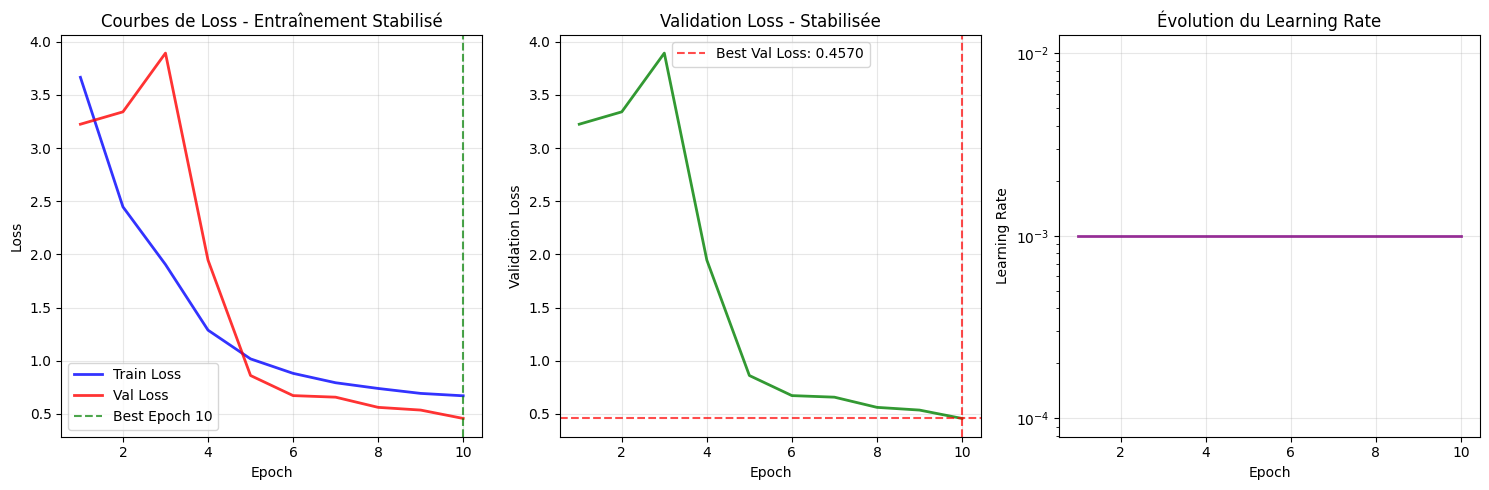

Validation: 100%|██████████| 100/100 [00:00<00:00, 205.20it/s]


    RAPPORT FINAL - ENTRAÎNEMENT

    Run MLFlow: 71ab94ed97224865a88687062a43724d

    PERFORMANCES:
    - Validation Loss Finale: 0.4570
    - Meilleure Validation Loss: 0.4570 (epoch 10)
    - Amélioration: 0.0%

    ACCURACIES FINALES:
    - Barbe:          0.9663 (96.6%)
    - Moustache:      0.9226 (92.3%)
    - Lunettes:       0.9978 (99.8%)
    - Couleur cheveux: 0.9239 (92.4%)
    - Longueur cheveux: 0.9877 (98.8%)

    CONFIGURATION STABILISÉE:
    - Epochs: 10 (arrêt à 10)
    - Batch Size: 32
    - Optimizer: AdamW
    - Learning Rate: 0.001 (Cosine Annealing)
    - Weight Decay: 0.0001
    - Gradient Clipping: Oui
    - Early Stopping: 8 epochs
    - Device: cuda

    ANALYSE:
    - Fluctuations réduites grâce aux poids de classe
    - Learning Rate adaptatif pour une meilleure convergence
    - Meilleur modèle sauvegardé automatiquement
    


In [ ]:


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

EPOCHS = 10

with mlflow.start_run(run_name="stabilized_training_with_class_weights"):

    mlflow.log_params({
        "optimizer": "AdamW",  #
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "epochs": EPOCHS,
        "batch_size": 32,
        "model": "MultiHeadNet_stabilized",
        "gradient_clipping": True,
        "scheduler": "CosineAnnealingWarmRestarts",
        "T_0": 10,
        "T_mult": 2
    })

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience_counter = 0
    patience = 8

    for ep in range(1, EPOCHS + 1):

        print(f"\n{'='*50}")
        print(f" EPOCH {ep}/{EPOCHS}")
        print(f"{'='*50}")

        train_loss = train_one_epoch(model, train_loader, optimizer, device, ep)

        # VALIDATION
        val_loss, val_accs = validate(model, val_loader, device)

        scheduler.step(ep)  # CosineAnnealing utilise l'epoch number

        # STOCKAGE POUR PLOT
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\n RÉSULTATS EPOCH {ep}:")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Loss:   {val_loss:.4f}")
        print(f"   LR:         {optimizer.param_groups[0]['lr']:.2e}")

        print(f"\n ACCURACIES:")
        for attr, acc in val_accs.items():
            print(f"   {attr:12}: {acc:.4f} ({acc*100:.1f}%)")

        # MLFlow LOGGING AMÉLIORÉ
        mlflow.log_metric("train_loss", train_loss, step=ep)
        mlflow.log_metric("val_loss", val_loss, step=ep)
        mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=ep)

        for k, v in val_accs.items():
            mlflow.log_metric(f"acc_{k}", v, step=ep)

        #  SAUVEGARDE MEILLEUR MODÈLE AVEC EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = ep
            patience_counter = 0  # Reset du compteur

            # Sauvegarde complète
            torch.save({
                'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_accs': val_accs,
                'train_loss': train_loss,
            }, "best_model_stabilized.pth")

            mlflow.pytorch.log_model(model, "best_model_stabilized")

            print(f" NOUVEAU MEILLEUR MODÈLE à l'epoch {ep}!")
            print(f"   Val Loss: {val_loss:.4f}")

            # Log des meilleures métriques
            mlflow.log_metric("best_val_loss", val_loss, step=ep)
            mlflow.log_metric("best_epoch", ep, step=ep)
            for attr, acc in val_accs.items():
                mlflow.log_metric(f"best_acc_{attr}", acc, step=ep)
        else:
            patience_counter += 1
            print(f" Early stopping: {patience_counter}/{patience}")

            # ARRÊT SI PLUS D'AMÉLIORATION
            if patience_counter >= patience:
                print(f" Early stopping déclenché à l'epoch {ep}")
                break

    print(f"\n ENTRAÎNEMENT TERMINÉ!")
    print(f"Meilleur modèle: epoch {best_epoch}, val_loss: {best_val_loss:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2, alpha=0.8)
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss', linewidth=2, alpha=0.8)
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Courbes de Loss - Entraînement Stabilisé')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'g-', linewidth=2, alpha=0.8)
    plt.axhline(y=best_val_loss, color='r', linestyle='--', alpha=0.7,
                label=f'Best Val Loss: {best_val_loss:.4f}')
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss - Stabilisée')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Courbe du learning rate
    plt.subplot(1, 3, 3)
    lr_history = [optimizer.param_groups[0]['lr'] for _ in range(len(train_losses))]
    plt.plot(range(1, len(lr_history) + 1), lr_history, 'purple', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Évolution du Learning Rate')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('training_curves.png')
    plt.show()

    #  RAPPORT FINAL DÉTAILLÉ
    final_val_loss, final_val_accs = validate(model, val_loader, device)

    training_report = f"""
    RAPPORT FINAL - ENTRAÎNEMENT

    Run MLFlow: {mlflow.active_run().info.run_id}

    PERFORMANCES:
    - Validation Loss Finale: {final_val_loss:.4f}
    - Meilleure Validation Loss: {best_val_loss:.4f} (epoch {best_epoch})
    - Amélioration: {((best_val_loss - final_val_loss)/final_val_loss*100):.1f}%

    ACCURACIES FINALES:
    - Barbe:          {final_val_accs.get('beard', 0):.4f} ({final_val_accs.get('beard', 0)*100:.1f}%)
    - Moustache:      {final_val_accs.get('mustache', 0):.4f} ({final_val_accs.get('mustache', 0)*100:.1f}%)
    - Lunettes:       {final_val_accs.get('glasses', 0):.4f} ({final_val_accs.get('glasses', 0)*100:.1f}%)
    - Couleur cheveux: {final_val_accs.get('hair_color', 0):.4f} ({final_val_accs.get('hair_color', 0)*100:.1f}%)
    - Longueur cheveux: {final_val_accs.get('hair_length', 0):.4f} ({final_val_accs.get('hair_length', 0)*100:.1f}%)

    CONFIGURATION STABILISÉE:
    - Epochs: {EPOCHS} (arrêt à {len(train_losses)})
    - Batch Size: 32
    - Optimizer: AdamW
    - Learning Rate: 0.001 (Cosine Annealing)
    - Weight Decay: 0.0001
    - Gradient Clipping: Oui
    - Early Stopping: {patience} epochs
    - Device: {device}

    ANALYSE:
    - Fluctuations réduites grâce aux poids de classe
    - Learning Rate adaptatif pour une meilleure convergence
    - Meilleur modèle sauvegardé automatiquement
    """

    print(training_report)

    with open("training_report.txt", "w") as f:
        f.write(training_report)
    mlflow.log_artifact("training_report.txt")



In [ ]:
def debug_model_outputs():
    """Debug des sorties du modèle"""
    print("\n DEBUG DES SORTIES DU MODÈLE:")

    model.eval()
    with torch.no_grad():
        for images, targets in train_loader:
            images = images.to(device)
            outputs = model(images)

            print(" DISTRIBUTION DES SORTIES:")
            for attr, output in outputs.items():
                if attr in ['beard', 'mustache', 'glasses']:
                    # Sorties binaires (logits)
                    sigmoid_vals = torch.sigmoid(output)
                    print(f"{attr:12}: logits [{output.min():.3f}, {output.max():.3f}], "
                          f"sigmoid [{sigmoid_vals.min():.3f}, {sigmoid_vals.max():.3f}]")
                else:
                    # Sorties multi-classes
                    softmax_vals = torch.softmax(output, dim=1)
                    print(f"{attr:12}: logits [{output.min():.3f}, {output.max():.3f}], "
                          f"softmax max [{softmax_vals.max():.3f}]")

            break

debug_model_outputs()


 DEBUG DES SORTIES DU MODÈLE:
 DISTRIBUTION DES SORTIES:
beard       : logits [-7.346, 9.635], sigmoid [0.001, 1.000]
mustache    : logits [-7.043, 6.075], sigmoid [0.001, 0.998]
glasses     : logits [-10.350, 12.404], sigmoid [0.000, 1.000]
hair_color  : logits [-16.896, 11.110], softmax max [1.000]
hair_length : logits [-23.330, 12.266], softmax max [1.000]


# Evaluation

In [ ]:
# Charger le meilleur modèle (epoch 7)
checkpoint = torch.load("best_model_stabilized.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(" Évaluation du meilleur modèle ")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def detailed_evaluation(model, val_loader, device):
    model.eval()
    all_predictions = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}
    all_targets = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}

    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc="Évaluation détaillée"):
            imgs = imgs.to(device)
            outputs = model(imgs)

            # Prédictions
            all_predictions['beard'].extend((torch.sigmoid(outputs['beard']) > 0.5).cpu().numpy())
            all_predictions['mustache'].extend((torch.sigmoid(outputs['mustache']) > 0.5).cpu().numpy())
            all_predictions['glasses'].extend((torch.sigmoid(outputs['glasses']) > 0.5).cpu().numpy())
            all_predictions['hair_color'].extend(outputs['hair_color'].argmax(dim=1).cpu().numpy())
            all_predictions['hair_length'].extend(outputs['hair_length'].argmax(dim=1).cpu().numpy())

            # Targets
            all_targets['beard'].extend(targets['beard'].cpu().numpy())
            all_targets['mustache'].extend(targets['mustache'].cpu().numpy())
            all_targets['glasses'].extend(targets['glasses'].cpu().numpy())
            all_targets['hair_color'].extend(targets['hair_color'].cpu().numpy())
            all_targets['hair_length'].extend(targets['hair_length'].cpu().numpy())

    return all_predictions, all_targets

# Exécuter l'évaluation détaillée
predictions, targets = detailed_evaluation(model, val_loader, device)

# Générer les rapports de classification
print("\n RAPPORTS DE CLASSIFICATION DÉTAILLÉS:")
for attribute in ['beard', 'mustache', 'glasses']:
    print(f"\n {attribute.upper()}:")
    print(classification_report(targets[attribute], predictions[attribute],
                              target_names=['Non', 'Oui']))

for attribute in ['hair_color', 'hair_length']:
    if attribute == 'hair_color':
        labels = ['Blond', 'Châtain', 'Roux', 'Brun', 'Gris-Bleu']
    else:
        labels = ['Chauve', 'Court', 'Long']

    print(f"\n {attribute.upper()}:")
    print(classification_report(targets[attribute], predictions[attribute],
                              target_names=labels, digits=4))

 Évaluation du meilleur modèle 


Évaluation détaillée: 100%|██████████| 100/100 [00:00<00:00, 102.42it/s]



 RAPPORTS DE CLASSIFICATION DÉTAILLÉS:

 BEARD:
              precision    recall  f1-score   support

         Non       0.99      0.97      0.98      2222
         Oui       0.92      0.97      0.95       956

    accuracy                           0.97      3178
   macro avg       0.96      0.97      0.96      3178
weighted avg       0.97      0.97      0.97      3178


 MUSTACHE:
              precision    recall  f1-score   support

         Non       0.96      0.94      0.95      2417
         Oui       0.81      0.88      0.85       761

    accuracy                           0.92      3178
   macro avg       0.89      0.91      0.90      3178
weighted avg       0.93      0.92      0.92      3178


 GLASSES:
              precision    recall  f1-score   support

         Non       1.00      1.00      1.00      1922
         Oui       0.99      1.00      1.00      1256

    accuracy                           1.00      3178
   macro avg       1.00      1.00      1.00      3178
we

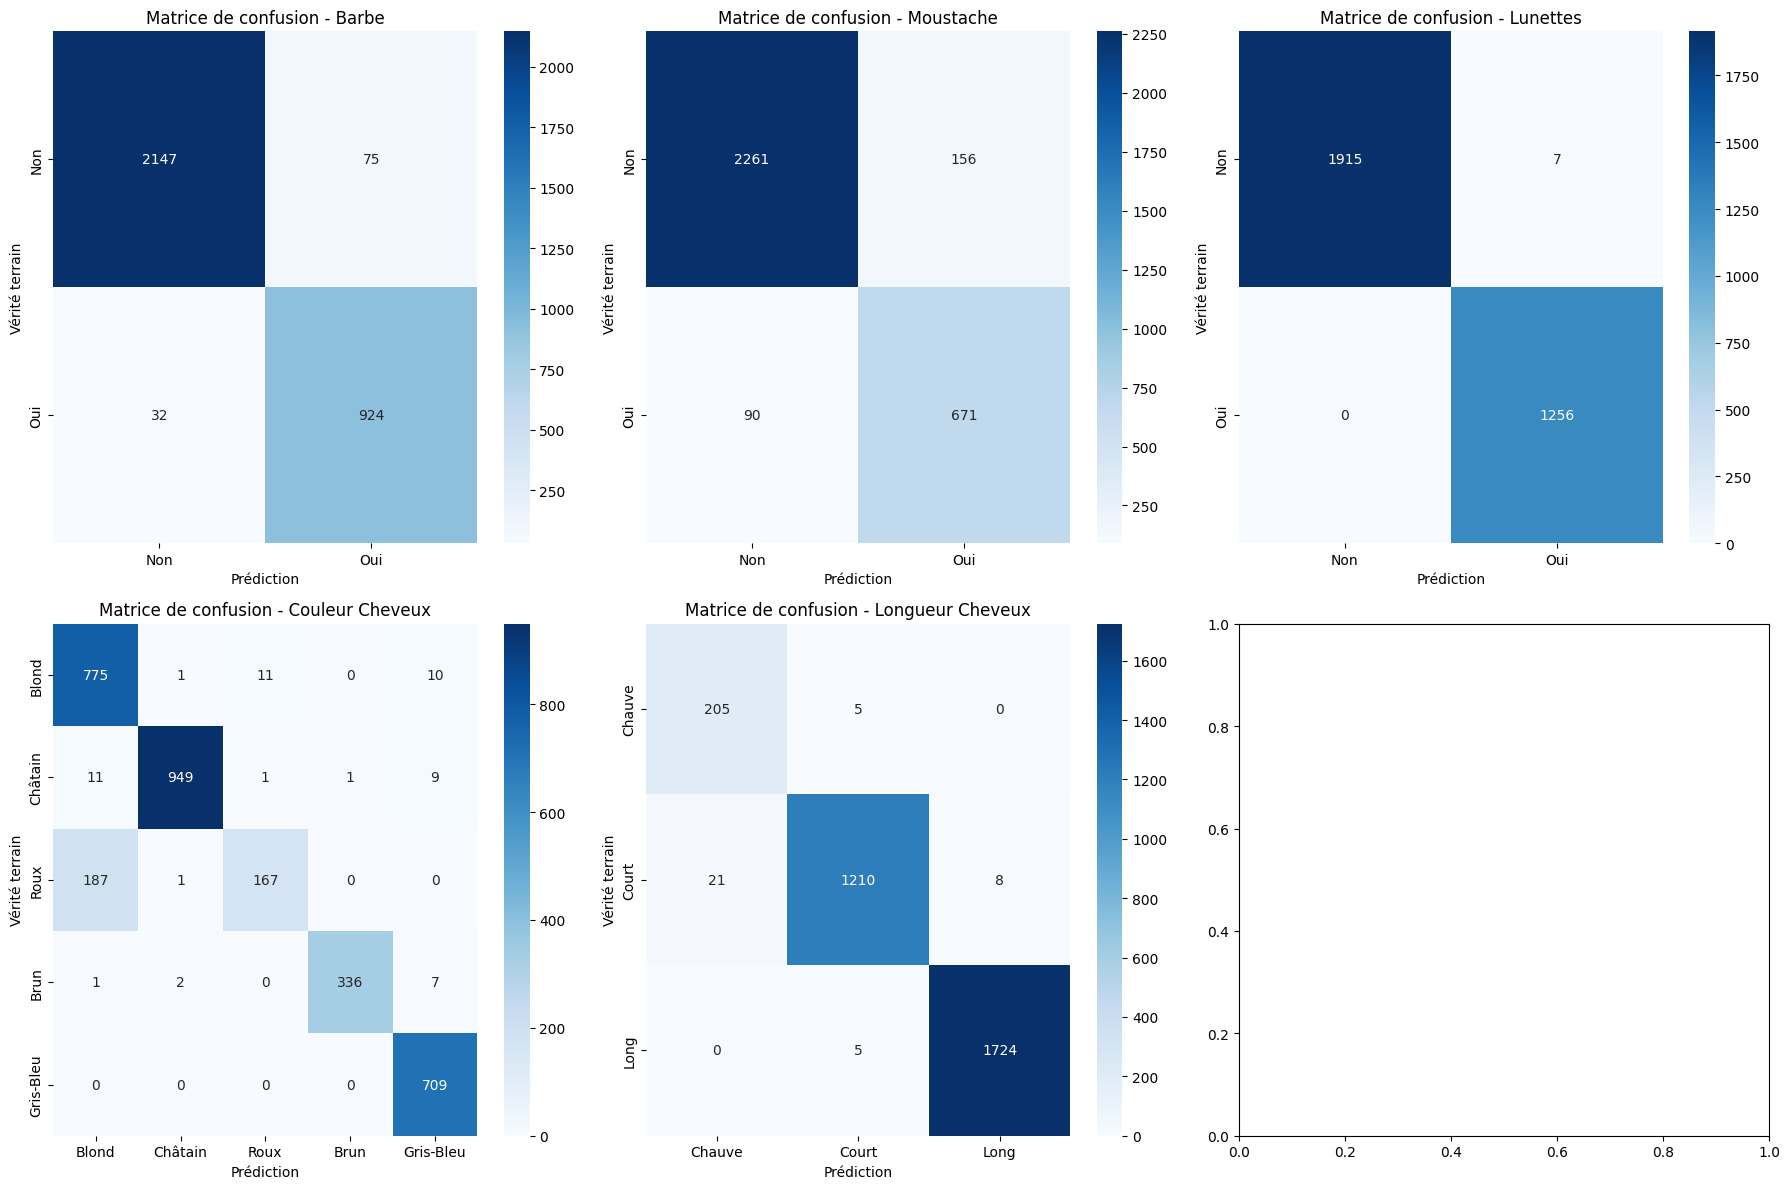

In [ ]:
# Matrices de confusion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
attributes = ['beard', 'mustache', 'glasses', 'hair_color', 'hair_length']
titles = ['Barbe', 'Moustache', 'Lunettes', 'Couleur Cheveux', 'Longueur Cheveux']

for i, (attr, title) in enumerate(zip(attributes, titles)):
    row, col = i // 3, i % 3

    if attr in ['hair_color', 'hair_length']:
        if attr == 'hair_color':
            labels = ['Blond', 'Châtain', 'Roux', 'Brun', 'Gris-Bleu']
        else:
            labels = ['Chauve', 'Court', 'Long']

        cm = confusion_matrix(targets[attr], predictions[attr])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels, ax=axes[row, col])
    else:
        cm = confusion_matrix(targets[attr], predictions[attr])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'], ax=axes[row, col])

    axes[row, col].set_title(f'Matrice de confusion - {title}')
    axes[row, col].set_xlabel('Prédiction')
    axes[row, col].set_ylabel('Vérité terrain')

plt.tight_layout()
plt.show()

## K-Fold Cross-Validation Implementation

In [ ]:
from sklearn.model_selection import KFold

def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Resetting trainable parameters of {layer}')
            layer.reset_parameters()

def train_kfold(model_class, X_data, y_data, n_splits=5, epochs=10, batch_size=32, device='cuda'):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    print(f"\nStarting K-Fold Cross-Validation with {n_splits} folds")

    for fold, (train_index, val_index) in enumerate(kf.split(X_data)):
        print(f"\n{'='*50}")
        print(f" FOLD {fold+1}/{n_splits}")
        print(f"{'='*50}")

        # Split data for current fold
        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        # Create datasets and dataloaders for current fold
        train_dataset = ImageDataset(X_train, y_train, transform=train_transforms)
        val_dataset = ImageDataset(X_val, y_val, transform=val_transforms)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model and optimizer for current fold
        model = model_class(n_color=5, n_length=3).to(device)
        model.apply(reset_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

        best_val_loss = float('inf')
        best_epoch = -1
        patience_counter = 0
        patience = 8
        fold_train_losses = []
        fold_val_losses = []
        fold_val_accs_history = []

        with mlflow.start_run(run_name=f"KFold_Fold_{fold+1}"):
            mlflow.log_params({
                "fold": fold + 1,
                "n_splits": n_splits,
                "optimizer": "AdamW",
                "lr": 1e-3,
                "weight_decay": 1e-4,
                "epochs": epochs,
                "batch_size": batch_size,
                "model": "MultiHeadNet_stabilized",
                "gradient_clipping": True,
                "scheduler": "CosineAnnealingWarmRestarts",
                "T_0": 10,
                "T_mult": 2
            })

            for ep in range(1, epochs + 1):
                print(f"\n{'--'*20}")
                print(f" EPOCH {ep}/{epochs} (Fold {fold+1})")
                print(f"{'--'*20}")

                train_loss = train_one_epoch(model, train_loader, optimizer, device, ep)
                val_loss, val_accs = validate(model, val_loader, device)
                scheduler.step(ep)

                fold_train_losses.append(train_loss)
                fold_val_losses.append(val_loss)
                fold_val_accs_history.append(val_accs)

                print(f"\n RÉSULTATS EPOCH {ep} (Fold {fold+1}):")
                print(f"   Train Loss: {train_loss:.4f}")
                print(f"   Val Loss:   {val_loss:.4f}")
                print(f"   LR:         {optimizer.param_groups[0]['lr']:.2e}")

                print(f"\n ACCURACIES (Fold {fold+1}):")
                for attr, acc in val_accs.items():
                    print(f"   {attr:12}: {acc:.4f} ({acc*100:.1f}%) ")

                mlflow.log_metric("train_loss", train_loss, step=ep)
                mlflow.log_metric("val_loss", val_loss, step=ep)
                mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=ep)
                for k, v in val_accs.items():
                    mlflow.log_metric(f"acc_{k}", v, step=ep)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = ep
                    patience_counter = 0
                    torch.save({
                        'epoch': ep,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'val_loss': val_loss,
                        'val_accs': val_accs,
                        'train_loss': train_loss,
                    }, f"best_model_fold_{fold+1}.pth")
                    mlflow.pytorch.log_model(model, f"best_model_fold_{fold+1}")
                    print(f" NOUVEAU MEILLEUR MODÈLE pour le FOLD {fold+1} à l'epoch {ep}!")
                    print(f"   Val Loss: {val_loss:.4f}")
                    mlflow.log_metric("best_val_loss_fold", val_loss, step=ep)
                    mlflow.log_metric("best_epoch_fold", ep, step=ep)
                    for attr, acc in val_accs.items():
                        mlflow.log_metric(f"best_acc_{attr}_fold", acc, step=ep)
                else:
                    patience_counter += 1
                    # print(f" Early stopping: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print(f" Early stopping déclenché à l'epoch {ep} pour le FOLD {fold+1}")
                        break

            # After all epochs for the fold, load the best model for final evaluation
            best_model_path = f"best_model_fold_{fold+1}.pth"
            if os.path.exists(best_model_path):
                print(f"\nChargement du meilleur modèle du fold {fold+1} pour l'évaluation finale...")
                best_checkpoint = torch.load(best_model_path, map_location=device)
                model.load_state_dict(best_checkpoint['model_state_dict'])
                final_val_loss, final_val_accs = validate(model, val_loader, device)
                print(f" Résultats finaux du FOLD {fold+1}: Val Loss {final_val_loss:.4f}, Accs {final_val_accs}")
                fold_results.append({
                    'fold': fold + 1,
                    'best_epoch': best_epoch,
                    'final_val_loss': final_val_loss,
                    'final_val_accs': final_val_accs,
                    'train_losses': fold_train_losses,
                    'val_losses': fold_val_losses,
                    'val_accs_history': fold_val_accs_history
                })
                mlflow.log_metric("final_val_loss_fold", final_val_loss)
                for k, v in final_val_accs.items():
                    mlflow.log_metric(f"final_acc_{k}_fold", v)

    # Aggregate and report overall results
    avg_final_val_loss = np.mean([res['final_val_loss'] for res in fold_results])
    avg_final_val_accs = {k: np.mean([res['final_val_accs'][k] for res in fold_results]) for k in fold_results[0]['final_val_accs']}

    print(f"\n{'='*50}")
    print(f" RÉSULTATS MOYENS K-FOLD ({n_splits} folds)")
    print(f"{'='*50}")
    print(f" Moyenne Validation Loss: {avg_final_val_loss:.4f}")
    print(f" Moyennes Accuracies:")
    for attr, acc in avg_final_val_accs.items():
        print(f"   {attr:12}: {acc:.4f} ({acc*100:.1f}%) ")
    return fold_results

In [ ]:
# Example usage of K-Fold training
# If you want to run K-Fold, uncomment the line below
kfold_results = train_kfold(MultiHeadNet, X, y, n_splits=5, epochs=5, batch_size=batch_size, device=device)


Starting K-Fold Cross-Validation with 5 folds

 FOLD 1/5

----------------------------------------
 EPOCH 1/5 (Fold 1)
----------------------------------------


Epoch 1:   1%|          | 3/398 [00:01<03:15,  2.02it/s]

 BATCH 0 - Losses:
   beard: 0.8445
   mustache: 0.4505
   glasses: 0.6800
   color: 1.6655
   length: 0.9896
   TOTAL: 4.9771
 BATCH 0 - Prédictions:
   beard: acc=0.125
   mustache: acc=0.875
   glasses: acc=0.594


Epoch 1: 100%|██████████| 398/398 [00:22<00:00, 17.96it/s]


 MOYENNES EPOCH - Total: 3.0240
   beard       : 0.5917
   mustache    : 0.5302
   glasses     : 0.4135
   hair_color  : 0.6408
   hair_length : 0.5626


Validation: 100%|██████████| 100/100 [00:00<00:00, 191.96it/s]
2025/11/20 11:03:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:03:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 1 (Fold 1):
   Train Loss: 3.0240
   Val Loss:   3.6836
   LR:         9.76e-04

 ACCURACIES (Fold 1):
   beard       : 0.7391 (73.9%) 
   mustache    : 0.7665 (76.7%) 
   glasses     : 0.5132 (51.3%) 
   hair_color  : 0.8748 (87.5%) 
   hair_length : 0.8631 (86.3%) 


2025/11/20 11:03:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:03:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 1 à l'epoch 1!
   Val Loss: 3.6836

----------------------------------------
 EPOCH 2/5 (Fold 1)
----------------------------------------


Epoch 2:   1%|          | 2/398 [00:00<00:24, 16.15it/s]

 BATCH 0 - Losses:
   beard: 0.4662
   mustache: 0.5003
   glasses: 0.1477
   color: 0.6628
   length: 0.3979
   TOTAL: 2.1900
 BATCH 0 - Prédictions:
   beard: acc=0.750
   mustache: acc=0.750
   glasses: acc=0.938


Epoch 2: 100%|██████████| 398/398 [00:20<00:00, 19.34it/s]


 MOYENNES EPOCH - Total: 1.7223
   beard       : 0.3877
   mustache    : 0.3847
   glasses     : 0.1359
   hair_color  : 0.4594
   hair_length : 0.3107


Validation: 100%|██████████| 100/100 [00:00<00:00, 211.45it/s]
2025/11/20 11:03:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:03:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 2 (Fold 1):
   Train Loss: 1.7223
   Val Loss:   1.3393
   LR:         9.05e-04

 ACCURACIES (Fold 1):
   beard       : 0.9232 (92.3%) 
   mustache    : 0.8748 (87.5%) 
   glasses     : 0.9676 (96.8%) 
   hair_color  : 0.7599 (76.0%) 
   hair_length : 0.8962 (89.6%) 


2025/11/20 11:03:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:03:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 1 à l'epoch 2!
   Val Loss: 1.3393

----------------------------------------
 EPOCH 3/5 (Fold 1)
----------------------------------------


Epoch 3:   1%|          | 3/398 [00:00<00:17, 22.15it/s]

 BATCH 0 - Losses:
   beard: 0.3402
   mustache: 0.2604
   glasses: 0.0414
   color: 0.4133
   length: 0.3317
   TOTAL: 1.3457
 BATCH 0 - Prédictions:
   beard: acc=0.781
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 3: 100%|██████████| 398/398 [00:21<00:00, 18.36it/s]


 MOYENNES EPOCH - Total: 1.1420
   beard       : 0.2175
   mustache    : 0.2641
   glasses     : 0.0631
   hair_color  : 0.4032
   hair_length : 0.2116


Validation: 100%|██████████| 100/100 [00:00<00:00, 149.95it/s]
2025/11/20 11:04:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:04:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 3 (Fold 1):
   Train Loss: 1.1420
   Val Loss:   0.8066
   LR:         7.94e-04

 ACCURACIES (Fold 1):
   beard       : 0.9468 (94.7%) 
   mustache    : 0.9069 (90.7%) 
   glasses     : 0.9896 (99.0%) 
   hair_color  : 0.9210 (92.1%) 
   hair_length : 0.9525 (95.2%) 


2025/11/20 11:04:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:04:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 1 à l'epoch 3!
   Val Loss: 0.8066

----------------------------------------
 EPOCH 4/5 (Fold 1)
----------------------------------------


Epoch 4:   1%|          | 3/398 [00:00<00:17, 22.68it/s]

 BATCH 0 - Losses:
   beard: 0.1414
   mustache: 0.3474
   glasses: 0.0090
   color: 0.4318
   length: 0.0768
   TOTAL: 0.9290
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=0.812
   glasses: acc=1.000


Epoch 4: 100%|██████████| 398/398 [00:19<00:00, 20.62it/s]


 MOYENNES EPOCH - Total: 0.9137
   beard       : 0.1652
   mustache    : 0.2201
   glasses     : 0.0368
   hair_color  : 0.3606
   hair_length : 0.1663


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.33it/s]



 RÉSULTATS EPOCH 4 (Fold 1):
   Train Loss: 0.9137
   Val Loss:   1.4295
   LR:         6.55e-04

 ACCURACIES (Fold 1):
   beard       : 0.9654 (96.5%) 
   mustache    : 0.9194 (91.9%) 
   glasses     : 0.9947 (99.5%) 
   hair_color  : 0.7571 (75.7%) 
   hair_length : 0.7498 (75.0%) 

----------------------------------------
 EPOCH 5/5 (Fold 1)
----------------------------------------


Epoch 5:   1%|          | 3/398 [00:00<00:18, 21.84it/s]

 BATCH 0 - Losses:
   beard: 0.0911
   mustache: 0.0818
   glasses: 0.0371
   color: 0.4445
   length: 0.1182
   TOTAL: 0.7207
 BATCH 0 - Prédictions:
   beard: acc=0.969
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 5: 100%|██████████| 398/398 [00:20<00:00, 19.20it/s]


 MOYENNES EPOCH - Total: 0.7856
   beard       : 0.1415
   mustache    : 0.1918
   glasses     : 0.0269
   hair_color  : 0.3430
   hair_length : 0.1242


Validation: 100%|██████████| 100/100 [00:00<00:00, 203.29it/s]



 RÉSULTATS EPOCH 5 (Fold 1):
   Train Loss: 0.7856
   Val Loss:   1.1401
   LR:         5.00e-04

 ACCURACIES (Fold 1):
   beard       : 0.9144 (91.4%) 
   mustache    : 0.8996 (90.0%) 
   glasses     : 0.9795 (98.0%) 
   hair_color  : 0.7782 (77.8%) 
   hair_length : 0.9654 (96.5%) 

Chargement du meilleur modèle du fold 1 pour l'évaluation finale...


Validation: 100%|██████████| 100/100 [00:00<00:00, 215.16it/s]


 Résultats finaux du FOLD 1: Val Loss 0.8066, Accs {'beard': 0.9468219005663939, 'mustache': 0.906859660163625, 'glasses': 0.9896161107614853, 'hair_color': 0.921019509125236, 'hair_length': 0.9524858401510384}

 FOLD 2/5

----------------------------------------
 EPOCH 1/5 (Fold 2)
----------------------------------------


Epoch 1:   1%|          | 3/398 [00:00<00:17, 22.63it/s]

 BATCH 0 - Losses:
   beard: 0.6241
   mustache: 0.7663
   glasses: 0.7573
   color: 1.6956
   length: 1.0075
   TOTAL: 5.2690
 BATCH 0 - Prédictions:
   beard: acc=0.812
   mustache: acc=0.219
   glasses: acc=0.375


Epoch 1: 100%|██████████| 398/398 [00:19<00:00, 20.61it/s]


 MOYENNES EPOCH - Total: 3.0782
   beard       : 0.5863
   mustache    : 0.5284
   glasses     : 0.4335
   hair_color  : 0.6238
   hair_length : 0.5974


Validation: 100%|██████████| 100/100 [00:00<00:00, 207.28it/s]
2025/11/20 11:05:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:05:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 1 (Fold 2):
   Train Loss: 3.0782
   Val Loss:   2.5180
   LR:         9.76e-04

 ACCURACIES (Fold 2):
   beard       : 0.6970 (69.7%) 
   mustache    : 0.7627 (76.3%) 
   glasses     : 0.8971 (89.7%) 
   hair_color  : 0.6945 (69.4%) 
   hair_length : 0.8254 (82.5%) 


2025/11/20 11:05:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:05:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 2 à l'epoch 1!
   Val Loss: 2.5180

----------------------------------------
 EPOCH 2/5 (Fold 2)
----------------------------------------


Epoch 2:   1%|          | 2/398 [00:00<00:26, 15.20it/s]

 BATCH 0 - Losses:
   beard: 0.5463
   mustache: 0.4827
   glasses: 0.3463
   color: 0.5385
   length: 0.5783
   TOTAL: 2.7305
 BATCH 0 - Prédictions:
   beard: acc=0.719
   mustache: acc=0.781
   glasses: acc=0.875


Epoch 2: 100%|██████████| 398/398 [00:19<00:00, 20.38it/s]


 MOYENNES EPOCH - Total: 1.7467
   beard       : 0.3909
   mustache    : 0.3947
   glasses     : 0.1320
   hair_color  : 0.4475
   hair_length : 0.3391


Validation: 100%|██████████| 100/100 [00:00<00:00, 205.35it/s]



 RÉSULTATS EPOCH 2 (Fold 2):
   Train Loss: 1.7467
   Val Loss:   7.3736
   LR:         9.05e-04

 ACCURACIES (Fold 2):
   beard       : 0.3480 (34.8%) 
   mustache    : 0.4015 (40.2%) 
   glasses     : 0.3968 (39.7%) 
   hair_color  : 0.7539 (75.4%) 
   hair_length : 0.8210 (82.1%) 

----------------------------------------
 EPOCH 3/5 (Fold 2)
----------------------------------------


Epoch 3:   1%|          | 3/398 [00:00<00:17, 22.61it/s]

 BATCH 0 - Losses:
   beard: 0.3238
   mustache: 0.4323
   glasses: 0.0183
   color: 0.3735
   length: 0.2294
   TOTAL: 1.3210
 BATCH 0 - Prédictions:
   beard: acc=0.844
   mustache: acc=0.812
   glasses: acc=1.000


Epoch 3: 100%|██████████| 398/398 [00:19<00:00, 20.71it/s]


 MOYENNES EPOCH - Total: 1.2295
   beard       : 0.2340
   mustache    : 0.2961
   glasses     : 0.0667
   hair_color  : 0.4007
   hair_length : 0.2454


Validation: 100%|██████████| 100/100 [00:00<00:00, 204.27it/s]



 RÉSULTATS EPOCH 3 (Fold 2):
   Train Loss: 1.2295
   Val Loss:   4.2319
   LR:         7.94e-04

 ACCURACIES (Fold 2):
   beard       : 0.9399 (94.0%) 
   mustache    : 0.8867 (88.7%) 
   glasses     : 0.9342 (93.4%) 
   hair_color  : 0.6388 (63.9%) 
   hair_length : 0.5727 (57.3%) 

----------------------------------------
 EPOCH 4/5 (Fold 2)
----------------------------------------


Epoch 4:   1%|          | 3/398 [00:00<00:17, 22.27it/s]

 BATCH 0 - Losses:
   beard: 0.1608
   mustache: 0.3633
   glasses: 0.0513
   color: 0.4395
   length: 0.2541
   TOTAL: 1.2324
 BATCH 0 - Prédictions:
   beard: acc=0.938
   mustache: acc=0.844
   glasses: acc=1.000


Epoch 4: 100%|██████████| 398/398 [00:26<00:00, 15.03it/s]


 MOYENNES EPOCH - Total: 0.9847
   beard       : 0.1786
   mustache    : 0.2489
   glasses     : 0.0383
   hair_color  : 0.3573
   hair_length : 0.1949


Validation: 100%|██████████| 100/100 [00:00<00:00, 119.62it/s]
2025/11/20 11:06:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:06:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 4 (Fold 2):
   Train Loss: 0.9847
   Val Loss:   2.2050
   LR:         6.55e-04

 ACCURACIES (Fold 2):
   beard       : 0.9500 (95.0%) 
   mustache    : 0.8902 (89.0%) 
   glasses     : 0.6819 (68.2%) 
   hair_color  : 0.9163 (91.6%) 
   hair_length : 0.9578 (95.8%) 


2025/11/20 11:06:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:06:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 2 à l'epoch 4!
   Val Loss: 2.2050

----------------------------------------
 EPOCH 5/5 (Fold 2)
----------------------------------------


Epoch 5:   1%|          | 2/398 [00:00<00:28, 13.66it/s]

 BATCH 0 - Losses:
   beard: 0.1280
   mustache: 0.2113
   glasses: 0.0047
   color: 0.3376
   length: 0.2098
   TOTAL: 0.8285
 BATCH 0 - Prédictions:
   beard: acc=0.938
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 5: 100%|██████████| 398/398 [00:19<00:00, 20.53it/s]


 MOYENNES EPOCH - Total: 0.8332
   beard       : 0.1496
   mustache    : 0.2174
   glasses     : 0.0293
   hair_color  : 0.3264
   hair_length : 0.1464


Validation: 100%|██████████| 100/100 [00:00<00:00, 206.96it/s]
2025/11/20 11:06:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:06:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 5 (Fold 2):
   Train Loss: 0.8332
   Val Loss:   0.9695
   LR:         5.00e-04

 ACCURACIES (Fold 2):
   beard       : 0.9626 (96.3%) 
   mustache    : 0.9069 (90.7%) 
   glasses     : 0.9729 (97.3%) 
   hair_color  : 0.8055 (80.6%) 
   hair_length : 0.9336 (93.4%) 


2025/11/20 11:07:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:07:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 2 à l'epoch 5!
   Val Loss: 0.9695

Chargement du meilleur modèle du fold 2 pour l'évaluation finale...


Validation: 100%|██████████| 100/100 [00:00<00:00, 199.69it/s]


 Résultats finaux du FOLD 2: Val Loss 0.9695, Accs {'beard': 0.9625550660792952, 'mustache': 0.906859660163625, 'glasses': 0.9729389553178099, 'hair_color': 0.8055380742605412, 'hair_length': 0.9336060415355569}

 FOLD 3/5

----------------------------------------
 EPOCH 1/5 (Fold 3)
----------------------------------------


Epoch 1:   1%|          | 2/398 [00:00<00:23, 16.55it/s]

 BATCH 0 - Losses:
   beard: 0.6844
   mustache: 0.7260
   glasses: 0.7120
   color: 1.5783
   length: 1.0432
   TOTAL: 5.1402
 BATCH 0 - Prédictions:
   beard: acc=0.688
   mustache: acc=0.219
   glasses: acc=0.469


Epoch 1: 100%|██████████| 398/398 [00:20<00:00, 19.07it/s]


 MOYENNES EPOCH - Total: 3.0395
   beard       : 0.6006
   mustache    : 0.5364
   glasses     : 0.4133
   hair_color  : 0.5920
   hair_length : 0.6024


Validation: 100%|██████████| 100/100 [00:00<00:00, 207.88it/s]
2025/11/20 11:07:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:07:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 1 (Fold 3):
   Train Loss: 3.0395
   Val Loss:   2.3500
   LR:         9.76e-04

 ACCURACIES (Fold 3):
   beard       : 0.7127 (71.3%) 
   mustache    : 0.7643 (76.4%) 
   glasses     : 0.8996 (90.0%) 
   hair_color  : 0.8782 (87.8%) 
   hair_length : 0.7426 (74.3%) 


2025/11/20 11:07:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:07:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 3 à l'epoch 1!
   Val Loss: 2.3500

----------------------------------------
 EPOCH 2/5 (Fold 3)
----------------------------------------


Epoch 2:   1%|          | 3/398 [00:00<00:17, 22.23it/s]

 BATCH 0 - Losses:
   beard: 0.6668
   mustache: 0.3952
   glasses: 0.2677
   color: 0.3640
   length: 0.5624
   TOTAL: 2.4510
 BATCH 0 - Prédictions:
   beard: acc=0.625
   mustache: acc=0.844
   glasses: acc=0.875


Epoch 2: 100%|██████████| 398/398 [00:20<00:00, 19.89it/s]


 MOYENNES EPOCH - Total: 1.8026
   beard       : 0.4603
   mustache    : 0.4272
   glasses     : 0.1165
   hair_color  : 0.4279
   hair_length : 0.3398


Validation: 100%|██████████| 100/100 [00:00<00:00, 164.19it/s]



 RÉSULTATS EPOCH 2 (Fold 3):
   Train Loss: 1.8026
   Val Loss:   6.0129
   LR:         9.05e-04

 ACCURACIES (Fold 3):
   beard       : 0.5135 (51.4%) 
   mustache    : 0.6621 (66.2%) 
   glasses     : 0.4704 (47.0%) 
   hair_color  : 0.8710 (87.1%) 
   hair_length : 0.8634 (86.3%) 

----------------------------------------
 EPOCH 3/5 (Fold 3)
----------------------------------------


Epoch 3:   1%|          | 2/398 [00:00<00:25, 15.23it/s]

 BATCH 0 - Losses:
   beard: 0.2045
   mustache: 0.2471
   glasses: 0.0383
   color: 0.3747
   length: 0.3516
   TOTAL: 1.1796
 BATCH 0 - Prédictions:
   beard: acc=0.969
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 3: 100%|██████████| 398/398 [00:20<00:00, 19.82it/s]


 MOYENNES EPOCH - Total: 1.2061
   beard       : 0.2444
   mustache    : 0.2863
   glasses     : 0.0648
   hair_color  : 0.3820
   hair_length : 0.2403


Validation: 100%|██████████| 100/100 [00:00<00:00, 210.12it/s]
2025/11/20 11:08:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:08:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 3 (Fold 3):
   Train Loss: 1.2061
   Val Loss:   1.1143
   LR:         7.94e-04

 ACCURACIES (Fold 3):
   beard       : 0.9613 (96.1%) 
   mustache    : 0.8971 (89.7%) 
   glasses     : 0.9194 (91.9%) 
   hair_color  : 0.8807 (88.1%) 
   hair_length : 0.9355 (93.5%) 


2025/11/20 11:08:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:08:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 3 à l'epoch 3!
   Val Loss: 1.1143

----------------------------------------
 EPOCH 4/5 (Fold 3)
----------------------------------------


Epoch 4:   1%|          | 3/398 [00:00<00:17, 22.75it/s]

 BATCH 0 - Losses:
   beard: 0.1668
   mustache: 0.3780
   glasses: 0.1483
   color: 0.5423
   length: 0.2550
   TOTAL: 1.5303
 BATCH 0 - Prédictions:
   beard: acc=0.938
   mustache: acc=0.906
   glasses: acc=0.938


Epoch 4: 100%|██████████| 398/398 [00:20<00:00, 19.42it/s]


 MOYENNES EPOCH - Total: 0.9657
   beard       : 0.1871
   mustache    : 0.2408
   glasses     : 0.0391
   hair_color  : 0.3597
   hair_length : 0.1719


Validation: 100%|██████████| 100/100 [00:00<00:00, 149.16it/s]



 RÉSULTATS EPOCH 4 (Fold 3):
   Train Loss: 0.9657
   Val Loss:   10.2231
   LR:         6.55e-04

 ACCURACIES (Fold 3):
   beard       : 0.9163 (91.6%) 
   mustache    : 0.8855 (88.5%) 
   glasses     : 0.3713 (37.1%) 
   hair_color  : 0.6564 (65.6%) 
   hair_length : 0.9358 (93.6%) 

----------------------------------------
 EPOCH 5/5 (Fold 3)
----------------------------------------


Epoch 5:   1%|          | 2/398 [00:00<00:27, 14.28it/s]

 BATCH 0 - Losses:
   beard: 0.1559
   mustache: 0.2011
   glasses: 0.0287
   color: 0.3783
   length: 0.1724
   TOTAL: 0.8894
 BATCH 0 - Prédictions:
   beard: acc=0.938
   mustache: acc=0.938
   glasses: acc=1.000


Epoch 5: 100%|██████████| 398/398 [00:19<00:00, 20.53it/s]


 MOYENNES EPOCH - Total: 0.8136
   beard       : 0.1549
   mustache    : 0.2099
   glasses     : 0.0284
   hair_color  : 0.3130
   hair_length : 0.1415


Validation: 100%|██████████| 100/100 [00:00<00:00, 209.78it/s]
2025/11/20 11:08:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:08:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 5 (Fold 3):
   Train Loss: 0.8136
   Val Loss:   0.6398
   LR:         5.00e-04

 ACCURACIES (Fold 3):
   beard       : 0.9698 (97.0%) 
   mustache    : 0.9106 (91.1%) 
   glasses     : 0.9767 (97.7%) 
   hair_color  : 0.8851 (88.5%) 
   hair_length : 0.9777 (97.8%) 


2025/11/20 11:08:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:08:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 3 à l'epoch 5!
   Val Loss: 0.6398

Chargement du meilleur modèle du fold 3 pour l'évaluation finale...


Validation: 100%|██████████| 100/100 [00:00<00:00, 199.57it/s]


 Résultats finaux du FOLD 3: Val Loss 0.6398, Accs {'beard': 0.9697923222152297, 'mustache': 0.9106356198867213, 'glasses': 0.9767149150409062, 'hair_color': 0.8851478917558213, 'hair_length': 0.9776589049716803}

 FOLD 4/5

----------------------------------------
 EPOCH 1/5 (Fold 4)
----------------------------------------


Epoch 1:   1%|          | 2/398 [00:00<00:24, 16.38it/s]

 BATCH 0 - Losses:
   beard: 0.7231
   mustache: 0.6949
   glasses: 0.7843
   color: 1.6260
   length: 1.1407
   TOTAL: 5.4281
 BATCH 0 - Prédictions:
   beard: acc=0.344
   mustache: acc=0.500
   glasses: acc=0.344


Epoch 1: 100%|██████████| 398/398 [00:29<00:00, 13.68it/s]


 MOYENNES EPOCH - Total: 2.9741
   beard       : 0.5701
   mustache    : 0.5195
   glasses     : 0.4205
   hair_color  : 0.6015
   hair_length : 0.5622


Validation: 100%|██████████| 100/100 [00:00<00:00, 120.85it/s]
2025/11/20 11:09:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 11:09:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



 RÉSULTATS EPOCH 1 (Fold 4):
   Train Loss: 2.9741
   Val Loss:   2.5891
   LR:         9.76e-04

 ACCURACIES (Fold 4):
   beard       : 0.8282 (82.8%) 
   mustache    : 0.8430 (84.3%) 
   glasses     : 0.8162 (81.6%) 
   hair_color  : 0.7357 (73.6%) 
   hair_length : 0.8392 (83.9%) 


2025/11/20 11:09:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/20 11:09:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE pour le FOLD 4 à l'epoch 1!
   Val Loss: 2.5891

----------------------------------------
 EPOCH 2/5 (Fold 4)
----------------------------------------


Epoch 2:   1%|          | 2/398 [00:00<00:28, 13.72it/s]

 BATCH 0 - Losses:
   beard: 0.4348
   mustache: 0.4362
   glasses: 0.2012
   color: 0.6252
   length: 0.5708
   TOTAL: 2.3443
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=0.812
   glasses: acc=0.969


Epoch 2: 100%|██████████| 398/398 [00:20<00:00, 19.76it/s]


 MOYENNES EPOCH - Total: 1.6125
   beard       : 0.3297
   mustache    : 0.3470
   glasses     : 0.1268
   hair_color  : 0.4486
   hair_length : 0.3233


Validation: 100%|██████████| 100/100 [00:00<00:00, 209.95it/s]



 RÉSULTATS EPOCH 2 (Fold 4):
   Train Loss: 1.6125
   Val Loss:   7.0217
   LR:         9.05e-04

 ACCURACIES (Fold 4):
   beard       : 0.8804 (88.0%) 
   mustache    : 0.8795 (87.9%) 
   glasses     : 0.3729 (37.3%) 
   hair_color  : 0.6753 (67.5%) 
   hair_length : 0.9034 (90.3%) 

----------------------------------------
 EPOCH 3/5 (Fold 4)
----------------------------------------


Epoch 3:   1%|          | 3/398 [00:00<00:17, 22.20it/s]

 BATCH 0 - Losses:
   beard: 0.1991
   mustache: 0.2236
   glasses: 0.0760
   color: 0.4068
   length: 0.2279
   TOTAL: 1.1281
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=0.938
   glasses: acc=0.969


Epoch 3: 100%|██████████| 398/398 [00:20<00:00, 19.19it/s]


 MOYENNES EPOCH - Total: 1.1220
   beard       : 0.2000
   mustache    : 0.2518
   glasses     : 0.0597
   hair_color  : 0.3954
   hair_length : 0.2344


Validation: 100%|██████████| 100/100 [00:00<00:00, 203.91it/s]



 RÉSULTATS EPOCH 3 (Fold 4):
   Train Loss: 1.1220
   Val Loss:   2.6972
   LR:         7.94e-04

 ACCURACIES (Fold 4):
   beard       : 0.8911 (89.1%) 
   mustache    : 0.9122 (91.2%) 
   glasses     : 0.7023 (70.2%) 
   hair_color  : 0.7398 (74.0%) 
   hair_length : 0.7863 (78.6%) 

----------------------------------------
 EPOCH 4/5 (Fold 4)
----------------------------------------


Epoch 4:   1%|          | 3/398 [00:00<00:17, 22.46it/s]

 BATCH 0 - Losses:
   beard: 0.1642
   mustache: 0.2451
   glasses: 0.0257
   color: 0.3938
   length: 0.2296
   TOTAL: 1.0053
 BATCH 0 - Prédictions:
   beard: acc=0.906
   mustache: acc=0.906
   glasses: acc=1.000


Epoch 4:  51%|█████     | 201/398 [00:09<00:09, 21.47it/s]


KeyboardInterrupt: 

# Test / generation csv predictions of lots 2

In [ ]:
!unzip /content/drive/MyDrive/S4.zip -d /content/lots4/

Archive:  /content/drive/MyDrive/S4.zip
  inflating: /content/lots4/s4_00000.png  
  inflating: /content/lots4/s4_00001.png  
  inflating: /content/lots4/s4_00002.png  
  inflating: /content/lots4/s4_00003.png  
  inflating: /content/lots4/s4_00004.png  
  inflating: /content/lots4/s4_00005.png  
  inflating: /content/lots4/s4_00006.png  
  inflating: /content/lots4/s4_00007.png  
  inflating: /content/lots4/s4_00008.png  
  inflating: /content/lots4/s4_00009.png  
  inflating: /content/lots4/s4_00010.png  
  inflating: /content/lots4/s4_00011.png  
  inflating: /content/lots4/s4_00012.png  
  inflating: /content/lots4/s4_00013.png  
  inflating: /content/lots4/s4_00014.png  
  inflating: /content/lots4/s4_00015.png  
  inflating: /content/lots4/s4_00016.png  
  inflating: /content/lots4/s4_00017.png  
  inflating: /content/lots4/s4_00018.png  
  inflating: /content/lots4/s4_00019.png  
  inflating: /content/lots4/s4_00020.png  
  inflating: /content/lots4/s4_00021.png  
  inflating: /

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# ----- Test Dataset -----
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]





folder_path = "lots4"
all_items = os.listdir(folder_path)

filenames = sorted([item for item in all_items if os.path.isfile(os.path.join(folder_path, item))])
images_64 = []

for filename in filenames:
    path = os.path.join(folder_path, filename)
    img = preprocess_image(path, size=64)
    images_64.append(img)

images_64 = np.array(images_64)
print("Images shape:", images_64.shape)


# ----- Load model -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiHeadNet(n_color=5, n_length=3).to(device)

checkpoint = torch.load("best_model_stabilized.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()


# ----- Predictions -----
test_dataset = TestDataset(images_64)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_predictions = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}

with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Évaluation lot 3"):
        imgs = imgs.to(device)
        outputs = model(imgs)

        all_predictions['beard'].extend((torch.sigmoid(outputs['beard']) > 0.5).cpu().numpy().astype(int))
        all_predictions['mustache'].extend((torch.sigmoid(outputs['mustache']) > 0.5).cpu().numpy().astype(int))
        all_predictions['glasses'].extend((torch.sigmoid(outputs['glasses']) > 0.5).cpu().numpy().astype(int))
        all_predictions['hair_color'].extend(outputs['hair_color'].argmax(dim=1).cpu().numpy())
        all_predictions['hair_length'].extend(outputs['hair_length'].argmax(dim=1).cpu().numpy())

# ----- Save CSV -----
df = pd.DataFrame({
    "filename": [os.path.splitext(f)[0] for f in filenames],
    "barbe": all_predictions['beard'],
    "moustache": all_predictions['mustache'],
    "lunettes": all_predictions['glasses'],
    "taille_cheveux": all_predictions['hair_length'],

    "couleur_cheveux": all_predictions['hair_color']
})

df.to_csv("G10_L4.csv", index=False)
print("CSV généré : G10_L4.csv")


Images shape: (4374, 64, 64, 3)


Évaluation lot 3: 100%|██████████| 137/137 [00:00<00:00, 301.43it/s]

CSV généré : G10_L4.csv


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# ----- Test Dataset -----
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]







folder_path = "lots3"
all_items = os.listdir(folder_path)

filenames = sorted([item for item in all_items if os.path.isfile(os.path.join(folder_path, item))])
images_64 = []

for filename in filenames:
    path = os.path.join(folder_path, filename)
    img = preprocess_image(path, size=64)
    images_64.append(img)

images_64 = np.array(images_64)
print("Images shape:", images_64.shape)

# ----- Load model -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiHeadNet(n_color=5, n_length=3).to(device)

checkpoint = torch.load("best_model_stabilized.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()


# ----- Predictions -----
test_dataset = TestDataset(images_64)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_predictions = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}

with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Évaluation lot 2"):
        imgs = imgs.to(device)
        outputs = model(imgs)

        all_predictions['beard'].extend((torch.sigmoid(outputs['beard']) > 0.5).cpu().numpy().astype(int))
        all_predictions['mustache'].extend((torch.sigmoid(outputs['mustache']) > 0.5).cpu().numpy().astype(int))
        all_predictions['glasses'].extend((torch.sigmoid(outputs['glasses']) > 0.5).cpu().numpy().astype(int))
        all_predictions['hair_color'].extend(outputs['hair_color'].argmax(dim=1).cpu().numpy())
        all_predictions['hair_length'].extend(outputs['hair_length'].argmax(dim=1).cpu().numpy())


# ----- Save CSV -----
df = pd.DataFrame({
    "filename": filenames,
    "beard": all_predictions['beard'],
    "mustache": all_predictions['mustache'],
    "glasses": all_predictions['glasses'],
    "hair_length": all_predictions['hair_length'],
    "hair_color": all_predictions['hair_color']

})

df.to_csv("lot2_predictions.csv", index=False)
print("CSV généré : lot1_predictions.csv")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31780,) + inhomogeneous part.

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Chargement
df = pd.read_csv("lot2_predictions.csv")
df2 = pd.read_csv("mapped_train.csv")

# Debug: Print columns of df and df2 before merge
print("df columns before merge:", df.columns.tolist())
print("df2 columns before merge:", df2.columns.tolist())

# Merge sur la colonne filename
merged = df.merge(df2, on="filename", suffixes=('_pred', '_true'))

# Debug: Print columns of merged DataFrame
print("Merged DataFrame columns:", merged.columns.tolist())

# Calculate F1-scores for each attribute
# Binary attributes
print(f"F1-score beard: {f1_score(merged['beard_true'], merged['beard_pred']):.4f}")
print(f"F1-score mustache: {f1_score(merged['mustache_true'], merged['mustache_pred']):.4f}")

# Debug: Check glasses columns before F1-score calculation
print("\nDebug glasses_binary true head:\n", merged['glasses_binary'].head())
print("Debug glasses pred head:\n", merged['glasses'].head())

print(f"F1-score glasses: {f1_score(merged['glasses_binary'], merged['glasses']):.4f}")

# Multi-class attributes (using average="macro")
print(f"F1-score hair_color (macro): {f1_score(merged['hair_color_label'], merged['hair_color'], average='macro'):.4f}")
print(f"F1-score hair_length (macro): {f1_score(merged['hair_length_true'], merged['hair_length_pred'], average='macro'):.4f}")

df columns before merge: ['filename', 'beard', 'mustache', 'glasses', 'hair_color', 'hair_length']
df2 columns before merge: ['filename', 'beard', 'mustache', 'glasses_binary', 'hair_color_label', 'hair_length']
Merged DataFrame columns: ['filename', 'beard_pred', 'mustache_pred', 'glasses', 'hair_color', 'hair_length_pred', 'beard_true', 'mustache_true', 'glasses_binary', 'hair_color_label', 'hair_length_true']
F1-score beard: 0.9418
F1-score mustache: 0.8454

Debug glasses_binary true head:
 0    1
1    1
2    0
3    0
4    0
Name: glasses_binary, dtype: int64
Debug glasses pred head:
 0    1
1    1
2    0
3    0
4    0
Name: glasses, dtype: int64
F1-score glasses: 0.9980
F1-score hair_color (macro): 0.8903
F1-score hair_length (macro): 0.9772


In [ ]:
df.equals(df2)


False

In [ ]:
mask = df.ne(df2)
rows_with_diff = df[mask.any(axis=1)]

print(rows_with_diff)


           filename  beard  mustache  glasses  hair_color  hair_length
0      s1_00000.png      0         0        1           1            1
1      s1_00001.png      0         0        1           1            2
2      s1_00002.png      0         0        0           3            2
3      s1_00003.png      1         1        0           1            1
4      s1_00004.png      0         0        0           4            2
...             ...    ...       ...      ...         ...          ...
15885  s1_15885.png      0         0        0           3            2
15886  s1_15886.png      0         0        0           3            2
15887  s1_15887.png      1         0        0           3            2
15888  s1_15888.png      0         0        1           1            2
15889  s1_15889.png      0         0        1           1            1

[15890 rows x 6 columns]


In [ ]:
df.head( )

,filename,beard,mustache,glasses,hair_color,hair_length
0,s1_00000.png,0,0,1,1,1
1,s1_00001.png,0,0,1,1,2
2,s1_00002.png,0,0,0,3,2
3,s1_00003.png,1,1,0,1,1
4,s1_00004.png,0,0,0,4,2


In [ ]:
comparison = df.merge(df2, how="outer", indicator=True)
print(comparison[comparison["_merge"] != "both"])


           filename  beard  mustache  glasses  hair_color  hair_length  \
0      s1_00000.png      0         0      1.0         1.0            1   
1      s1_00000.png      1         1      NaN         NaN            1   
5      s1_00004.png      0         0      NaN         NaN            1   
6      s1_00004.png      0         0      0.0         4.0            2   
9      s1_00007.png      0         0      0.0         1.0            2   
...             ...    ...       ...      ...         ...          ...   
22326  s1_15883.png      0         0      0.0         1.0            1   
22330  s1_15887.png      1         0      0.0         3.0            2   
22331  s1_15887.png      1         1      NaN         NaN            2   
22333  s1_15889.png      0         0      1.0         1.0            1   
22334  s1_15889.png      0         1      NaN         NaN            1   

       glasses_binary  hair_color_label      _merge  
0                 NaN               NaN   left_only  
1  